# Home First Model Training


**Current updates**

- this notebook optimizes the feature selection for each of the 4 models..
- ADD HOW HERE...


**Previous 3.0 Updates**
- trys to optimize SNF (SNF Pianobar) model in the following ways:
    - build dummy classifier to get baseline performance metrics
    - test other models
    - research other features that could improve performance
        - added the following columns that were in data already and were correlated with target varirable:
             - 'SNF_DX_2_Risk_normalized',
             - 'Female_normalized',
             - 'SNF_DX_3_Risk_normalized',
             - 'NPI_risk_normalized',
             - 'DX3_Risk_normalized',
             - 'DX2_Risk_normalized',
             - 'Historical_DX3_readmission_risk_normalized'
             - 'total_admit_count_normalized'
    - tried model performance with and without normalization
    - tried model performance by filling na with 0s, means and medians
    
**Previous 2.1 NB Updates**
- uses PDM Claims Wellcare FL data to train the model

Previous 2.0 NB Updates:
- in this notebook for FL Blue we use PDM OPS instead of PDM CLAIMS b/c there was no FL BLue claims data at the time
- we use an optimized version of charlston index variable creation to decrease code run time
- we tried to utilize a new way of defining variables used in the models, however it failed when trying to make predictions in the current mail merge code, so reverting back to the old way of defining variables 
- ensured all models had AUC scores and feature importance outputs printed
- used pandas profiling to observe data (in html format)
- added code to view columns used to train each model


Previous Updates:
- in this notebook we used the stable production table PDM_CLAIMS TO TRAIN instead of PDM_DEV_EPISODIC
- when creating the dx_risk and snf_risk scores we retianed the client differentiation as the risk scores by client seem to be different by client 
    - some of this is explained by client's different market and patient base
    - however we chose to keep this in b/c of the separate exlusion rules different clients' have (ie. some clients exclude chemotherapy and this would change the dx risk scores if the data was aggreated and not broken out by client 
- also for the input sql data this code does not utilize the client differentiated scope tables for gathering member gender and member zip, instead it gets these fields from pdm claims
- **currently the data is filtered for OPTIMA, and may need to have the svi/icd tables updated**

# Imports

In [189]:
#Importing libraries, loading the data

import timeit
#start = timeit.default_timer()
import pickle
import pandas as pd
import statsmodels.formula.api as sm
from datetime import date
import numpy as np
import math
import random
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.datasets
from sklearn.dummy import DummyClassifier
import pandas
import numpy as np
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pickle

import treeinterpreter as ti

#comment to hide graphics
%matplotlib inline

#set matplot lib style to 538
plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
import seaborn as sns

#pandas profiling
from pandas_profiling import ProfileReport

In [2]:
#Vertica Library
import vertica_python
from verticapy.utilities import *

In [3]:

# Compare Algorithms
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time
# creating zscores
import scipy.stats as stats

In [5]:
#get time of beginning of code
startCodeTime = time.time()

# User Defined Functions

In [6]:
#define function to explore model outcomes
#by limiting model inputs using feature importances
def test_model_feats_imprts(dataframe_full, target, remove_var_list, protected):
    '''test model outcomes with variety of columns selected using their feature importance in predicting target variable, checks for protected class use'''
    #max out rows used to 30,000 (to keep run times reasonable)
    if len(dataframe_full) > 30000:
        #if table greater than 30k rows take 30k sample
        print('getting 30k rows sample of data')
        dataframe = dataframe_full.sample(30000).reset_index(drop=True)
    else: #else use whatever size they have
        dataframe = dataframe_full
    #get total rows in df
    total_rows = len(dataframe)
    #get full list of model variables, minus remove var list
    model_vars_full = list(set(dataframe.columns) - set(remove_var_list))
    
    #Assign target
    y = dataframe[target]
    #assign x variables for when using all variables
    X_full = dataframe[model_vars_full]

    # setting up testing and training sets
    X_trainF, X_testF, y_trainF, y_testF = train_test_split(X_full, 
                                                        y, 
                                                        test_size=0.2, #Assign test size, note also used to create small data sets to train on
                                                        random_state=42, #assign random state for reproducbility
                                                        stratify=y #use this for classification problems
                                                       )
    
    #create  model with all variables
    model_full = RandomForestClassifier()
    print('fitting/predicting w/ dummy model...')
    #fit dummy classifier
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_trainF, y_trainF)
    #get accuracy scores for training & testing data sets
    dummy_acc = dummy_clf.score(X_testF, y_testF)
    #fit model with all model variables
    print('fitting model with all columns...')
    model_full.fit(X_trainF,y_trainF,sample_weight=None)
    print('model fitting complete')
    #create empty list
    feat_list = []
    #get feature importances
    feat_imp = sorted(zip(map(lambda x:round(x,4), model_full.feature_importances_),X_full),reverse = True)
    #add feat imp to list
    for num, feat in feat_imp:
        feat_list.append([feat,num])
    #covnert to dataframe
    featImp_eval = pd.DataFrame(feat_list, columns=['feature', 'importance'])
    #set empty list to capture outputs for later dataframe
    print('feature importance buffer testing...')
    #create blank list for column numbers
    col_nums = []
    #creat blank list for dataframe coulumn values
    col_list = []
    for i in range(0,1001):
        featImp_buff = (i/1000)
        start_time = time.time()
        #get all vars in that have feat importance at or above buff
        featImp_list = list(featImp_eval[featImp_eval['importance'] >=featImp_buff]['feature'])
        #remove any columns that are not to be used
        #to create column list for model
        model_vars = list(set(featImp_list) - set(remove_var_list))
        #get number of columns used for model
        num_cols = len(model_vars)
        #if there are no more columns, don't do anythin
        if num_cols == 0:
            pass
        #if the number of columns has been done before skip
        elif num_cols in col_nums:
            pass
        else:    
            #add number of columns to the col num history list
            col_nums.append(num_cols)
            #if there are no protected classes used in model
            #set to 1 else 0
            if (len(protected) == len(set(protected) - set(model_vars))) == True:
                has_protect_class = 0
            else:
                has_protect_class = 1
            #assign x variables
            X = dataframe[model_vars]

            # setting up testing and training sets
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size=0.2, #Assign test size, note also used to create small data sets to train on
                                                                random_state=42, #assign random state for reproducbility
                                                                stratify=y #use this for classification problems
                                                               )

            #create  model
            model = RandomForestClassifier()
            #fit model
            model.fit(X_train,y_train,sample_weight=None)

            #create predictions and AUC curve
            predictions = model.predict_proba(X_test)
            fpr, tpr, thr = metrics.roc_curve(y_test,predictions[:,1],pos_label = 1)
            #get AUC score
            last = metrics.auc(fpr,tpr)
            #get test and training accuracy
            train_acc = model.score(X_train, y_train)
            test_acc = model.score(X_test, y_test)

            #get f1-score of positive class
            pstv_f1 = classification_report(y_test, model.predict(X_test), output_dict=True)['1']['f1-score']
            
            end_time = time.time()
            run_time = end_time - start_time 
            runTime_min = round(run_time/60, 2)
            #append variables to list
            #multiply probabilities by 100 to get precentange
            col_list.append([featImp_buff*100, last*100, num_cols, train_acc*100, test_acc*100, dummy_acc*100, pstv_f1*100,  has_protect_class, total_rows, model_vars,runTime_min])
            #print for visual control
            print(featImp_buff*100, '% buffer done in', runTime_min, 'min')
            
    #convert list of lists to dataframe
    featImp_tests = pd.DataFrame(col_list, columns=['featImp_buff', 'AUC', 'num_cols', 'train_acc', 'test_acc', 'dummy_acc', 'pstv_f1',  'has_protect_class', 'total_rows','model_vars','runTime_min'])
    #get percent change from dummy accuracy and test accuracy
    featImp_tests['accr%Chng_fromDummy'] = ((featImp_tests.test_acc - featImp_tests.dummy_acc)/featImp_tests.dummy_acc)*100
    return featImp_tests, featImp_eval

In [7]:
#define function to explore model outcomes
#builds the correlation correlations into the function
def test_model_feats_corr(dataframe_full, target, remove_var_list, protected):
    '''test model outcomes with a variety of columns selected using their corr to the target variable, check for protected class use'''
    #max out rows used to 30,000 (to keep run times reasonable)
    if len(dataframe_full) > 30000:
        #if table greater than 30k rows take 30k sample
        print('getting 30k rows sample of data')
        dataframe = dataframe_full.sample(30000).reset_index(drop=True)
    else: #else use whatever size they have
        dataframe = dataframe_full
    #get total rows in df
    total_rows = len(dataframe)
    #get correlations of all variables with target variable
    #pearson corr
    PCorr_df = dataframe.corr().reset_index()[['index',target]]
    print('pearson corr complete')
    #kendall corr
    SCorr_df = dataframe.corr(method='kendall').reset_index()[['index',target]]
    print('kendall corr complete')
    #spearman corr
    KCorr_df = dataframe.corr(method='spearman').reset_index()[['index',target]]
    print('spearman corr complete')
    #create blank list for column numbers
    col_nums = []
    #set empty list to capture outputs for later dataframe
    col_list = []
    for i in range(0,101):
        corr_buff = (i/100)
        start_time = time.time()
        #get all vars in that have correlation at or above buff
        #for 3 correlation tests
        Pcorr_list = list(PCorr_df[PCorr_df[target].abs() >=corr_buff]['index'])
        Scorr_list = list(SCorr_df[SCorr_df[target].abs() >=corr_buff]['index'])
        Kcorr_list = list(KCorr_df[KCorr_df[target].abs() >=corr_buff]['index'])
        #combine all three corr lists together
        #remove any columns that are not to be used
        #to create column list for model
        model_vars = list(set(Pcorr_list+Scorr_list+Kcorr_list) - set(remove_var_list))
        #get number of columns used for model
        num_cols = len(model_vars)
        #if there are no more columns, don't do anythin
        if num_cols == 0:
            pass
        #if the number of columns has been done before skip
        elif num_cols in col_nums:
            pass
        else:    
            #add number of columns to the col num history list
            col_nums.append(num_cols)
            #if there are no protected classes used in model
            #set to 1 else 0
            if (len(protected) == len(set(protected) - set(model_vars))) == True:
                has_protect_class = 0
            else:
                has_protect_class = 1
            #Assign target
            y = dataframe[target]
            #assign x variables
            X = dataframe[model_vars]

            # setting up testing and training sets
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size=0.2, #Assign test size, note also used to create small data sets to train on
                                                                random_state=42, #assign random state for reproducbility
                                                                stratify=y #use this for classification problems
                                                               )

            #create  model
            model = RandomForestClassifier()
            #fit model
            model.fit(X_train,y_train,sample_weight=None)

            #create predictions and AUC curve
            predictions = model.predict_proba(X_test)
            fpr, tpr, thr = metrics.roc_curve(y_test,predictions[:,1],pos_label = 1)
            #get AUC score
            last = metrics.auc(fpr,tpr)
            #if all feature importances are beings used then create feature importance dataframe 
            #else skip
            if corr_buff == 0:
                #create empty list
                feat_list = []
                #get feature importances
                feat_imp = sorted(zip(map(lambda x:round(x,4), model.feature_importances_),X),reverse = True)
                #add feat imp to list
                for num, feat in feat_imp:
                    feat_list.append([feat,num])
                #covnert to dataframe
                featImp_eval = pd.DataFrame(feat_list, columns=['feature', 'importance'])

            else:
                pass
            #get test and training accuracy
            train_acc = model.score(X_train, y_train)
            test_acc = model.score(X_test, y_test)

            #get f1-score of positive class
            pstv_f1 = classification_report(y_test, model.predict(X_test), output_dict=True)['1']['f1-score']

            #fit dummy classifier
            dummy_clf = DummyClassifier(strategy="most_frequent")
            dummy_clf.fit(X_train, y_train)
            #get accuracy scores for training & testing data sets
            #dummy_clf.score(X_train, y_train)
            dummy_acc = dummy_clf.score(X_test, y_test)
            
            #calculate run time
            end_time = time.time()
            run_time = end_time - start_time 
            runTime_min = round(run_time/60, 2)
            #append variables to list
            #multiply probabilities by 100 to get precentange
            col_list.append([corr_buff*100, last*100, num_cols, train_acc*100, test_acc*100, dummy_acc*100, pstv_f1*100,  has_protect_class, total_rows, model_vars,runTime_min])
            #print for visual control
            print(corr_buff*100, '% buffer done in', runTime_min, 'min')
    #convert list of lists to dataframe
    corr_eval = pd.DataFrame(col_list, columns=['corr_buffer', 'AUC', 'num_cols', 'train_acc', 'test_acc', 'dummy_acc', 'pstv_f1', 'has_protect_class', 'total_rows','model_vars','runTime_min'])
    #get percent change from dummy accuracy and test accuracy
    corr_eval['accr%Chng_fromDummy'] = ((corr_eval.test_acc - corr_eval.dummy_acc)/corr_eval.dummy_acc)*100
    return corr_eval, featImp_eval

In [8]:
#Takes in a list, returns list with no repeated values
#no longer used
#def to_unique(l):
 #   return list(dict.fromkeys(l))

#Takes in a list of field names, appends n_dim principal components from those fields to the global dataframe
def pca_to_df(list_of_var_names, n_dims, col_description, df):
    #comment out this _normalized line when using non standardized data
    #need to then include standardization here?
    list_of_var_names = [s + '_normalized' for s in list_of_var_names]
    print(list_of_var_names)
    pca = PCA(n_components = n_dims, random_state = 3)
    #may need to fillna with mean (or create list of means for those col names in filter)
    pca.fit(df[list_of_var_names].fillna(0))#.dropna()) #GET RID OF FILLNA 0
    pca_frame = pd.DataFrame(pca.components_, columns = list_of_var_names)
    x_reduced_trn = pca.transform(df[list_of_var_names].fillna(0)) #GET RID OF FILLNA 0 (change to mean)
    #x_reduced_tst = pca.transform(test_data[list_of_var_names].fillna(0))
    dims = {}
    for i in range(n_dims):
        df[col_description + 'PC'+ str(i) + '_normalized'] = x_reduced_trn[:,i]
        #test_data[col_description + 'PC'+ str(i) + '_normalized'] = x_reduced_tst[:,i]
        pc.append(col_description + 'PC'+str(i))
    loadings = pd.DataFrame(pca.components_.T, columns = ['PC0','PC1','PC2'], index = list_of_var_names)    
    return pca
        
#UDF to check for specific conditions based on description of DX
def scan_diagnoses(condition):
    claims_data['DX1_'+condition] =claims_data['DX1_Description'].str.contains(condition,regex=True)
    claims_data['DX2_' + condition] =0#data['DX2_Description'].str.contains(condition,regex=True)
    claims_data['DX3_' + condition] =0#data['DX3_Description'].str.contains(condition,regex=True)
    claims_data[condition] = np.where(claims_data['DX1_'+condition] | claims_data['DX2_'+condition] | claims_data['DX3_'+condition],1,0)

 #FUNCTIONS (_hist..) needed for charlston index   
def hist_MicrocardialInfarction(codes):
    
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {"I21","I22"}
        string_full = {"I252"}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
    return 0
def hist_CHF(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {"I43","I50"}
        string_full = {'I099' ,'I110', 'I130', 'I132', 'I255', 'I420','I425','I426','I427','I428', 'I429','P290'}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
    return 0
def hist_PeripheralVascular(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        #Devon Wildcards the Z's    
        string_full = {'I731','I738','I739','I771','I790','I792','K551','K558','K559','Z958','Z959'}
        string_3 = {"I70",'I71'}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
    return 0
def hist_Cerebrovascular(codes):
    #I63 not wildcarded in Devon's coding
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {'G45','G46'}
        string_full = {"H340"}
        string_2 = {'I6'}
        if code[:3] in string_3:
            return 1
        if code[:2] in string_2:
            return 1
        if code[:4] in string_full:
            return 1
    return 0
def hist_Dementia(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {"F00","F01",'F02','F03','G30'}
        string_full = {'F051','G311'}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
    return 0
def hist_Pulmonary(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {'J40','J41','J42','J43','J44','J45','J46','J47','J60','J61','J62','J63','J64','J65','J66','J67'}
        string_full = {'I278','I279','J684','J701','J703'}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
    return 0
def hist_Rheumatic(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        #Devon Includes J43*    
        string_3 = {'M05','M06','M32','M33','M34'}
        string_2 = {}
        string_full = {'M315','M351','M353','M360'}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_PepticUlcer(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {'K25','K26','K27','K28'}
        string_2 = {}
        string_full = {}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_MildLiver(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {'B18','K73','K74'}
        string_2 = {}
        string_full = {'K700','K701','K702','K703','K709','K713','K714','K715','K717','K760','K762','K763','K764','K768','K769','Z944'}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_DiabetesWithout(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {}
        string_2 = {}        
        string_full = {"E100", "E10l", "E106", "E108", "E109","E110", "E111", "E116", "E118", "E119", "E120", "E121", "E126", "E128", "E129", "E130", "E131"," E136"," E138", "E139", "E140", "E141", "E146", "E148", "E149"} 
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_DiabetesWith(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {}
        string_2 = {}
        string_full = {'E102','E103','E104','E105','E107','E112','E113','E114','E115','E117','E122','E123','E124','E125','E127','E132','E133','E134','E135','E137','E142','E143','E144','E145','E147'}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_Hemiplegia(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {'G81','G82'}
        string_2 = {}
        string_full = {'G041','G114','G801','G802','G830','G831','G832','G833','G834','G839'}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_Renal(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_full = {'I120','I131','N032','N033','N034','N035','N036','N037','N052','N053','N054','N055','N056','N057','N250','Z490','Z491','Z492','Z940','Z992'}
        string_3 = {'N18','N19'}
        string_2 = {}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_Malignancy(codes):
    for code in codes:
        if not isinstance(code, str):
           
            continue            
        string_3 = {'C20','C22','C23','C24','C25','C26','C30','C31','C32','C33','C34','C37','C38','C39','C40','C41','C43','C45','C46','C47','C48','C49','C50','C51','C52','C53','C54','C55','C56','C57','C58','C70','C71','C72','C73','C74','C75','C76','C81','C82','C83','C84','C85','C88','C90','C91','C92','C93','C94','C95','C96','C97'}
        #Note prior coding excluded C0*
        string_2 = {'C1','C6'}
        string_full = {}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_Liver(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {}
        string_2 = {}
        string_full = {'I850','I859','I864','I982','K704','K711','K721','K729','K765','K766','K767'}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_Metastatic(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {'C77','C78','C79','C80'}
        string_2 = {}
        string_full = {}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0
def hist_AIDSHIV(codes):
    for code in codes:
        if not isinstance(code, str):
            continue
        string_3 = {'B20','B21','B22','B24'}
        string_2 = {}
        string_full = {}
        if code[:3] in string_3:
            return 1
        if code[:4] in string_full:
            return 1
        if code[:2] in string_2:
            return 1
    return 0

In [9]:
#define functions to explore a pandas dataframe 
def data_explore_func(dataframe):
    '''explore dataframe columns, dtypes, info, unique values, min, max, mean, and check for NaNs/duplicates'''
    print('List of Dataframe Columns\n\n',dataframe.columns)
    #print('\n\nData Types in this Dataframe\n\n',dataframe.dtypes)
    print('\n\nInfo of this Dataframe\n')
    print(dataframe.info())
    print('\n\nUnique Values (by column) in this Dataframe\n\n',dataframe.nunique().sort_values(ascending=False))
    print('\n\nUnique Values (by column) as % in this Dataframe\n\n',(dataframe.nunique()/len(dataframe)*100).sort_values(ascending=False))
    print('\n\nUnique Values for Every Column as (%)\n')
    for col in dataframe.columns:
        print(col)
        print(dataframe[col].value_counts()/len(dataframe[col])*100)
        print('\n')
    print('\n\nSummary Statistics of this Dataframe\n\n',dataframe.describe(include='all'))
    print('\n\nNull Values by Column as (%)')
    print((dataframe.isna().sum()/len(dataframe)*100).sort_values(ascending=False))
    print('\n\nDuplicates in this Dataframe\n',len(dataframe[dataframe.duplicated()]))
    print('Duplicates as a % of total Dataframe\n',len(dataframe[dataframe.duplicated()])/len(dataframe)*100)

# Data Initialization

### Vertica Connection

In [10]:
#Read in values
with open(r'C:\Users\JJFRASC\Documents\CCx Projects\Vertica_Extractions\vertica1.txt') as f:
#version on VM
#with open(r'C:\Users\Product_Reporting_Sv\Desktop\Python Projects\JJFRASC\Vertica_Extractions\vertica1.txt') as f:
    vertica1 = f.read()
    f.close()
    
with open(r'C:\Users\JJFRASC\Documents\CCx Projects\Vertica_Extractions\vertica2.txt') as f:
#version on VM
#with open(r'C:\Users\Product_Reporting_Sv\Desktop\Python Projects\JJFRASC\Vertica_Extractions\vertica2.txt') as f:
    vertica2 = f.read()
    f.close()

# Build vertica connection
vert_str = {
            'host': 'P1VERTICA', #production environment
            #'host': 'D1VERTICA', #developer environment
            'port': 5433,
            'user': vertica1, #enter your username
            'password': vertica2,  #enter your password
            'database': 'P1DA01', #production environment
            #'database': 'D1DA01', #developer environment
            'read_timeout': 600,
            'unicode_error': 'strict',
            'ssl': True
            }

In [11]:
#get SNF provider rankings by county
hhaRating_byCnty_sql = '''
--get HHA provider rankings by county
SELECT 
STATE, COUNTY,
--fill not rated with nulls and get summary stats for ccx provider rankings
COUNT(*) AS PROV_COUNTS,
AVG(NULLIF(FINAL_TOTAL_RATING, 'Not Rated')) AS AVG_PROV_RATING,
MAX(NULLIF(FINAL_TOTAL_RATING, 'Not Rated')) AS MAX_PROV_RATING,
MIN(NULLIF(FINAL_TOTAL_RATING, 'Not Rated')) AS MIN_PROV_RATING
FROM  datalab_work_prd.CMS_Home_Health_Risk_Adjusted
GROUP BY 1,2
ORDER BY AVG_PROV_RATING DESC;
'''

In [12]:
#get SNF provider rankings by county
snfRating_byCnty_sql = '''
--get SNF provider rankings by county
SELECT 
PROVIDER_STATE, PROVIDER_COUNTY,
--fill not rated with nulls and get summary stats for ccx provider rankings
COUNT(*) AS PROV_COUNTS,
AVG(NULLIF(FINAL_TOTAL_RATING, 'Not Rated')) AS AVG_PROV_RATING,
MAX(NULLIF(FINAL_TOTAL_RATING, 'Not Rated')) AS MAX_PROV_RATING,
MIN(NULLIF(FINAL_TOTAL_RATING, 'Not Rated')) AS MIN_PROV_RATING
FROM  datalab_work_prd.CMS_SNF_Risk_Adjusted
GROUP BY 1,2
ORDER BY AVG_PROV_RATING DESC;
'''

In [13]:
#bring in input data (operations but labeled as claims for lazy code updates)
ops_data_sql = '''
SELECT * FROM DATALAB_WORK_PRD.POC_TRAINING_DATA3
WHERE PERIOD <= ADD_MONTHS(PAID_THRU_DATE, -5) 
--AND DATA_SOURCE = 'OPERATIONAL' 
LIMIT 150000
;
'''

In [306]:
#for snf model only 
#b/c not getting sufficient data to train on whole pull

#bring in input data (operations but labeled as claims for lazy code updates)
only_snf_sql = '''
SELECT * FROM (
SELECT *
,CASE WHEN Discharge_To='IRF' THEN 1 
WHEN Discharge_To='SNF' THEN 1 
ELSE 0 END AS SNF_or_IRF
FROM DATALAB_WORK_PRD.POC_TRAINING_DATA3
WHERE PERIOD <= ADD_MONTHS(PAID_THRU_DATE, -5) 
) foo
WHERE SNF_OR_IRF = 1
LIMIT 30000
;


'''

## Note about snf risk model:
if not enough rows to train with others, then may need to pull in only_snf_sql and just run the snf risk model to get best columns

In [307]:
%%time
#Vertica connection to extract data from Vertica table
with vertica_python.connect(**vert_str) as connection:
    #create connection
    cur = connection.cursor('dict')
    
    #extract hha ratings by county
    cur.execute(hhaRating_byCnty_sql)
    hhaRating_byCnty = pd.DataFrame(cur.fetchall())
    
    #extract snf ratings by county
    cur.execute(snfRating_byCnty_sql)
    snfRating_byCnty = pd.DataFrame(cur.fetchall())
    
    #get input data for models
    cur.execute(ops_data_sql)
    claims_data = pd.DataFrame(cur.fetchall())
    
    #use this one if only training snf model (when 1st run doesn't have enough rows) 
    #cur.execute(only_snf_sql)
    #claims_data = pd.DataFrame(cur.fetchall())

Wall time: 1min 23s


#### (operations data but labeled as claims for lazy code updates)

# Explore Input Data - EDA

In [15]:
#data_explore_func(claims_data)

In [16]:
claims_data.dtypes

NPI                                               float64
CLIENT                                             object
MBR_ID                                             object
PERIOD                                     datetime64[ns]
ROW_NUM                                             int64
PAID_THRU_DATE                                     object
DATA_SOURCE                                        object
MEMBER_ID                                          object
MEMBER_ID_ORIG                                     object
SUBSCRIBER_ID                                      object
MEMBER_LAST_NAME                                   object
MEMBER_FIRST_NAME                                  object
MEMBER_DOB                                         object
MEMBER_AGE                                        float64
MEMBER_GENDER                                      object
MEMBER_ADDRESS_LINE_1                              object
MEMBER_ADDRESS_LINE_2                              object
MEMBER_ZIP    

In [308]:
%%time
#define columns to convert to float
cols_to_float = ['EPI_ID_READMIT_RISK_R', 
    'BILLED_AMT',
'TOTAL_ALWD',
'UNDER_18_ALWD',
'MENTAL_DRG_ALWD',
'MATERNITY_DRG_ALWD',
'MENTAL_DIAG_ALWD',
'MATERNITY_DIAG_ALWD',
'TRANSPLANT_ALWD',
'ESRD_ALWD',
'CHEMO_ALWD',
'ORPHAN_ALWD',
'HS_Elig_Alwd',
    'READMIT_RISK_R',
    'Latitude',
'Longitude',
    'flu_byMemMonths',
'awv_byMemMonths',
'ofv_byMemMonths',
'flu_byMemDays',
'awv_byMemDays',
'ofv_byMemDays',
'flu_byMemMonths_recent',
'awv_byMemMonths_recent',
'ofv_byMemMonths_recent',
'flu_byMemDays_recent',
'awv_byMemDays_recent',
'ofv_byMemDays_recent',
'total_admit_count_byMemMonths_CLAIMS',
'total_admit_count_byMemMonths_OPS',
'total_admit_count_byMemDays_CLAIMS',
'total_admit_count_byMemDays_OPS',
'hist_readmit_90_rate_byMemMonths_CLAIMS',
'hist_readmit_90_rate_byMemMonths_OPS',
'hist_readmit_90_rate_byMemDays_CLAIMS',
'hist_readmit_90_rate_byMemDays_OPS',
'Count_180_byMemMonths_CLAIMS',
'Count_180_byMemMonths_OPS',
'Count_180_byMemDays_CLAIMS',
'Count_180_byMemDays_OPS',
'Count_365_byMemMonths_CLAIMS',
'Count_365_byMemMonths_OPS',
'Count_365_byMemDays_CLAIMS',
'Count_365_byMemDays_OPS',
'Historical_DX1_readmission_risk_CLAIMS',
'Historical_DX1_readmission_risk_OPS',
'Historical_DX2_readmission_risk_CLAIMS',
'Historical_DX2_readmission_risk_OPS',
'Historical_DX3_readmission_risk_CLAIMS',
'Historical_DX3_readmission_risk_OPS',
'MAX_Adj_DX_1_RR_CLAIMS',
'MAX_Adj_DX_1_RR_OPS',
'MAX_Adj_DX_2_RR_CLAIMS',
'MAX_Adj_DX_2_RR_OPS',
'MAX_Adj_DX_3_RR_CLAIMS',
'MAX_Adj_DX_3_RR_OPS',
'Historical_DX1_SNF_risk_CLAIMS',
'Historical_DX1_SNF_risk_OPS',
'Historical_DX2_SNF_risk_CLAIMS',
'Historical_DX2_SNF_risk_OPS',
'Historical_DX3_SNF_risk_CLAIMS',
'Historical_DX3_SNF_risk_OPS',
'MAX_Adj_DX_1_SNF_rate_CLAIMS',
'MAX_Adj_DX_1_SNF_rate_OPS',
'MAX_Adj_DX_2_SNF_rate_CLAIMS',
'MAX_Adj_DX_2_SNF_rate_OPS',
'MAX_Adj_DX_3_SNF_rate_CLAIMS',
'MAX_Adj_DX_3_SNF_rate_OPS',
'data_source_rr_rate_CLAIMS',
'data_source_rr_rate_OPS',
'Adj_NPI_risk_CLAIMS',
'Adj_NPI_risk_OPS',
'NPI_risk_CLAIMS',
'NPI_risk_OPS',
'Adj_DX_1_RR_CLAIMS',
'Adj_DX_1_RR_OPS',
'Adj_DX_1_SNF_rate_CLAIMS',
'Adj_DX_1_SNF_rate_OPS',
'Adj_DX_2_RR_CLAIMS',
'Adj_DX_2_RR_OPS',         
'Adj_DX_2_SNF_rate_CLAIMS',
'Adj_DX_2_SNF_rate_OPS',   
'Adj_DX_3_RR_CLAIMS',      
'Adj_DX_3_RR_OPS',         
'Adj_DX_3_SNF_rate_CLAIMS',
'Adj_DX_3_SNF_rate_OPS']

#convert these colums to floats
claims_data[cols_to_float] = claims_data[cols_to_float].apply(pd.to_numeric, errors='coerce')

Wall time: 15.5 s


In [309]:
claims_data.describe()

NPI       ROW_NUM    MEMBER_AGE  MEMBER_BACKFILLED_ADDRESS  \
count  2.990100e+04   30000.00000  29327.000000                    30000.0   
mean   1.480965e+09  109012.42480     72.485252                        0.0   
std    2.913733e+08   89671.83878     12.200142                        0.0   
min    1.003050e+09       1.00000      0.000000                        0.0   
25%    1.235197e+09   41388.00000     65.000000                        0.0   
50%    1.457456e+09   88069.00000     73.000000                        0.0   
75%    1.710932e+09  152908.75000     81.000000                        0.0   
max    1.992880e+09  417356.00000    107.000000                        0.0   

       MEMBER_FRONTFILLED_RECORD     CLIENT_ID  PFFS_FLAG  SCOPE_FLAG  \
count                    30000.0  30000.000000    17473.0     30000.0   
mean                         0.0    302.080567        0.0         1.0   
std                          0.0    107.691586        0.0         0.0   
min                          0.0     71.000000        0.0         1.0   
25%                          0.0    333.000000        0.0         1.0   
50%                          0.0    333.000000        0.0         1.0   
75%                          0.0    333.000000        0.0         1.0   
max                          0.0    394.000000        0.0         1.0   

       MEDECON_MEMBER_ROSTER_CHECK  IN_834_CHECK   EPI_ID_ORIG  \
count                 30000.000000  30000.000000  1.239900e+04   
mean                      0.716400      0.581233  3.290042e+07   
std                       0.450752      0.493365  2.778496e+07   
min                       0.000000      0.000000  2.600000e+01   
25%                       0.000000      0.000000  8.184045e+05   
50%                       1.000000      1.000000  5.684156e+07   
75%                       1.000000      1.000000  5.690481e+07   
max                       1.000000      1.000000  5.696965e+07   

       EPI_ADMIT_TYPE  EPI_IS_READMIT_30_DAY  EPI_IS_READMIT_90_DAY  \
count     4138.000000           30000.000000           30000.000000   
mean         1.698888               0.174733               0.287067   
std          1.905224               0.379745               0.452401   
min          1.000000               0.000000               0.000000   
25%          1.000000               0.000000               0.000000   
50%          1.000000               0.000000               0.000000   
75%          1.000000               0.000000               1.000000   
max          9.000000               1.000000               1.000000   

       EPI_HAS_COVID  EPI_HOS_HAS_COVID  EPI_IS_READMIT_W_COVID_90  \
count   30000.000000       30000.000000               30000.000000   
mean        0.036133           0.032667                   0.008567   
std         0.186625           0.177766                   0.092161   
min         0.000000           0.000000                   0.000000   
25%         0.000000           0.000000                   0.000000   
50%         0.000000           0.000000                   0.000000   
75%         0.000000           0.000000                   0.000000   
max         1.000000           1.000000                   1.000000   

        EPI_HAS_PAC   EPI_HAS_HHA   EPI_HAS_SNF   EPI_HAS_IRF  EPI_HAS_LTAC  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       0.999967      0.013433      0.875267      0.140667      0.000667   
std        0.005774      0.115123      0.330422      0.347683      0.025812   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      1.000000      0.000000      0.000000   
50%        1.000000      0.000000      1.000000      0.000000      0.000000   
75%        1.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       EPI_ID_READMIT_RISK_R  EPI_DAYS_TO_READMIT  EPI_HAS_READMIT_90_DAY  \


### SNF/HHA Ratings by County

In [310]:
#change max and min columns to float
snfRating_byCnty['MAX_PROV_RATING'] = snfRating_byCnty.MAX_PROV_RATING.astype(float)
snfRating_byCnty['MIN_PROV_RATING'] = snfRating_byCnty.MIN_PROV_RATING.astype(float)
hhaRating_byCnty['MAX_PROV_RATING'] = hhaRating_byCnty.MAX_PROV_RATING.astype(float)
hhaRating_byCnty['MIN_PROV_RATING'] = hhaRating_byCnty.MIN_PROV_RATING.astype(float)

In [311]:
#data_explore_func(snfRating_byCnty)

In [312]:
#data_explore_func(hhaRating_byCnty)

### Claims Data

In [313]:
len(claims_data)

30000

In [314]:
#get how many columns there are
len(claims_data.columns)

296

In [315]:
#DROP ANY COLUMNS THAT ARE ALL NULL
claims_data.dropna(axis=1, how='all', inplace=True)
#see how many columns we have now
len(claims_data.columns)

290

In [316]:
#drop row number column from data load
#if exists
try:
    claims_data.drop(columns='Unnamed: 0', inplace=True)
    
except:
    pass

In [317]:
#data_explore_func(claims_data)

In [318]:
claims_data.describe()

NPI       ROW_NUM    MEMBER_AGE  MEMBER_BACKFILLED_ADDRESS  \
count  2.990100e+04   30000.00000  29327.000000                    30000.0   
mean   1.480965e+09  109012.42480     72.485252                        0.0   
std    2.913733e+08   89671.83878     12.200142                        0.0   
min    1.003050e+09       1.00000      0.000000                        0.0   
25%    1.235197e+09   41388.00000     65.000000                        0.0   
50%    1.457456e+09   88069.00000     73.000000                        0.0   
75%    1.710932e+09  152908.75000     81.000000                        0.0   
max    1.992880e+09  417356.00000    107.000000                        0.0   

       MEMBER_FRONTFILLED_RECORD     CLIENT_ID  PFFS_FLAG  SCOPE_FLAG  \
count                    30000.0  30000.000000    17473.0     30000.0   
mean                         0.0    302.080567        0.0         1.0   
std                          0.0    107.691586        0.0         0.0   
min                          0.0     71.000000        0.0         1.0   
25%                          0.0    333.000000        0.0         1.0   
50%                          0.0    333.000000        0.0         1.0   
75%                          0.0    333.000000        0.0         1.0   
max                          0.0    394.000000        0.0         1.0   

       MEDECON_MEMBER_ROSTER_CHECK  IN_834_CHECK   EPI_ID_ORIG  \
count                 30000.000000  30000.000000  1.239900e+04   
mean                      0.716400      0.581233  3.290042e+07   
std                       0.450752      0.493365  2.778496e+07   
min                       0.000000      0.000000  2.600000e+01   
25%                       0.000000      0.000000  8.184045e+05   
50%                       1.000000      1.000000  5.684156e+07   
75%                       1.000000      1.000000  5.690481e+07   
max                       1.000000      1.000000  5.696965e+07   

       EPI_ADMIT_TYPE  EPI_IS_READMIT_30_DAY  EPI_IS_READMIT_90_DAY  \
count     4138.000000           30000.000000           30000.000000   
mean         1.698888               0.174733               0.287067   
std          1.905224               0.379745               0.452401   
min          1.000000               0.000000               0.000000   
25%          1.000000               0.000000               0.000000   
50%          1.000000               0.000000               0.000000   
75%          1.000000               0.000000               1.000000   
max          9.000000               1.000000               1.000000   

       EPI_HAS_COVID  EPI_HOS_HAS_COVID  EPI_IS_READMIT_W_COVID_90  \
count   30000.000000       30000.000000               30000.000000   
mean        0.036133           0.032667                   0.008567   
std         0.186625           0.177766                   0.092161   
min         0.000000           0.000000                   0.000000   
25%         0.000000           0.000000                   0.000000   
50%         0.000000           0.000000                   0.000000   
75%         0.000000           0.000000                   0.000000   
max         1.000000           1.000000                   1.000000   

        EPI_HAS_PAC   EPI_HAS_HHA   EPI_HAS_SNF   EPI_HAS_IRF  EPI_HAS_LTAC  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       0.999967      0.013433      0.875267      0.140667      0.000667   
std        0.005774      0.115123      0.330422      0.347683      0.025812   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      1.000000      0.000000      0.000000   
50%        1.000000      0.000000      1.000000      0.000000      0.000000   
75%        1.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       EPI_ID_READMIT_RISK_R  EPI_DAYS_TO_READMIT  EPI_HAS_READMIT_90_DAY  \


In [319]:
#look at when member age is less than 0
#consider recalculating it with member dob and current date?
claims_data[claims_data.MEMBER_AGE<0]

Empty DataFrame
Columns: [NPI, CLIENT, MBR_ID, PERIOD, ROW_NUM, PAID_THRU_DATE, DATA_SOURCE, MEMBER_ID, MEMBER_ID_ORIG, SUBSCRIBER_ID, MEMBER_LAST_NAME, MEMBER_FIRST_NAME, MEMBER_DOB, MEMBER_AGE, MEMBER_GENDER, MEMBER_ADDRESS_LINE_1, MEMBER_ADDRESS_LINE_2, MEMBER_ZIP, MEMBER_CITY, MEMBER_COUNTY, MEMBER_STATE, MEMBER_BACKFILLED_ADDRESS, MEMBER_FRONTFILLED_RECORD, IPA_ID, IPA_AFFILIATION, IPA_NAME, CLIENT_ID, LEGACY_FLAG, PLAN_STATE, PRODUCT, REFINED_PRODUCT, PFFS_FLAG, GO_LIVE_DATE, CONTRACT_PERIOD, PLAN_CODE, PLAN_CODE_SHORT, SCOPE_FLAG, MEDECON_MEMBER_ROSTER_CHECK, IN_834_CHECK, EPI_ID, EPI_ID_ORIG, EPI_HOS_ADMIT_DATE, EPI_HOS_DISCHARGE_DATE, EPI_ADMIT_TYPE, EPI_END_DATE, EPI_HOS_DISCHARGE_FACILITY_NM, EPI_IS_READMIT_30_DAY, EPI_IS_READMIT_90_DAY, EPI_HAS_COVID, EPI_HOS_HAS_COVID, EPI_IS_READMIT_W_COVID_90, EPI_HAS_PAC, EPI_HAS_HHA, EPI_HAS_SNF, EPI_HAS_IRF, EPI_HAS_LTAC, EPI_ID_READMIT_RISK_R, EPI_ID_DRG, EPI_ID_DRG_WEIGHTS, EPI_FIRST_DAY_HOME, EPI_ENGAGEMENT_DATE, EPI_ENGAGED_CE, EPI_DAYS_TO_READMIT, EPI_HAS_READMIT_90_DAY, EPI_HAS_READMIT_30_DAY, EPI_HAS_READMIT_W_COVID_90, EPI_READMIT_DATE, EPI_READMIT_DISCHARGE_DATE, EPI_READMIT_FACILITY_NM_ORIG, EPI_READMIT_FACILITY_NPI_ORIG, EPI_READMIT_DRG, EPI_READMIT_DRG_DESCRIPTION, EPI_READMIT_FACILITY_NPI, EPI_READMIT_FACILITY_NM, EPI_READMIT_SYSTEM, EPI_HOS_DX1, EPI_READMIT_DX1, EPI_LAST_FACILITY, EPI_READMIT_DAYS_SINCE_LAST_FAC_DSCHRG, EPI_READMIT_FROM_PAC_FAC_FLAG, EPI_PAT_ITK_ID, NEXT_EPI_HOS_IS_IN_SCOPE, EPI_HOS_CAN_BE_READMIT, PAC_STY_ID, PAC_STY_ID_ORIG, COVID_START_FLAG, IS_IP_TRANSFER, STAY_MONTH, STAY_DATE, STAY_ADMIT_DATE, STAY_DISCHARGE_DATE, STAY_HAS_COVID, POS, FACILITY_NPI_ORIG, FACILITY_NAME_ORIG, FACILITY_NPI, FACILITY_NAME, SYSTEM, Latitude, Longitude, ...]
Index: []

## Excel read in

In [320]:
#CDC
#Go to https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html
#Select Year: most recent year, Geography: United States, Geography: Census Tracts, File Type: CSV File
#Click “Go”
svi_data = pd.read_csv('C:\\Users\JJFRASC\Documents\CCx Projects\Advanced Data Labs Projects\Path of Care Model\All Clients\Model\data\zip_svi_map_102821.csv')

#list of ICD 10 codes with descriptions
#https://www.cms.gov/medicare/icd-10/2022-icd-10-pcs
#updates yearly and just need to pull the current year
#make sure you select ICD-10 PCS which is for inpatients
icd10 = pd.read_csv('C:\\Users\JJFRASC\Documents\CCx Projects\Advanced Data Labs Projects\Path of Care Model\All Clients\Model\data\ICD10 Descriptions and Counts.csv')

#Data sourced from Lexis Nexis
#ln_df = pd.read_csv(ln_file).fillna(0)

In [321]:
svi_data.head()

ZIP     E_NOVEH    E_CROWD    E_MOBILE  RPL_THEMES     EP_POV  RPL_THEME4  \
0   501   75.000000  12.000000    0.000000    0.207700   6.600000    0.467500   
1  1001  150.500000   8.666667   11.833333    0.286583   7.483333    0.341433   
2  1002  157.111111  17.444444    6.666667    0.336878  25.444444    0.516600   
3  1005   44.333333  15.333333   20.000000    0.182467   5.033333    0.392367   
4  1007  140.000000  28.000000  176.500000    0.175950   5.150000    0.334450   

   RPL_THEME3  RPL_THEME2  RPL_THEME1  
0    0.533400    0.033100     0.26640  
1    0.333383    0.469717     0.26780  
2    0.375489    0.190489     0.44170  
3    0.081833    0.180033     0.29890  
4    0.274300    0.201500     0.16705

In [322]:
icd10.head()

Code                                        Description
0   A000  Cholera due to Vibrio cholerae 01, biovar chol...
1   A001    Cholera due to Vibrio cholerae 01, biovar eltor
2   A009                               Cholera, unspecified
3  A0100                         Typhoid fever, unspecified
4  A0101                                 Typhoid meningitis

In [323]:
#data_explore_func(svi_data)

In [324]:
svi_data.describe()

ZIP       E_NOVEH       E_CROWD      E_MOBILE    RPL_THEMES  \
count  17623.000000  17623.000000  17623.000000  17623.000000  17623.000000   
mean   49495.986098    115.324298     44.929759    169.198322     -0.342955   
std    28357.755724    154.368877     53.992348    226.976426     22.513607   
min        0.000000      0.000000      0.000000      0.000000   -999.000000   
25%    27408.500000     47.000000     13.000000      9.500000      0.288275   
50%    48032.000000     84.000000     28.416667     79.500000      0.480700   
75%    74522.000000    137.000000     55.275000    245.132479      0.668650   
max    99926.000000   3165.000000   1045.000000   2994.000000      0.999700   

             EP_POV    RPL_THEME4    RPL_THEME3    RPL_THEME2    RPL_THEME1  
count  17623.000000  17623.000000  17623.000000  17623.000000  17623.000000  
mean      14.159666      0.495935      0.408625      0.528450     -0.333179  
std       17.174516      0.226246      0.261306      1.103075     22.514033  
min     -999.000000      0.000000      0.000000   -142.349000   -999.000000  
25%        7.700000      0.326717      0.185600      0.347300      0.292212  
50%       12.455556      0.497600      0.375600      0.549214      0.493200  
75%       18.820833      0.663775      0.604717      0.730431      0.686717  
max      100.000000      0.999800      0.999500      0.999300      1.000000

In [325]:
#data_explore_func(icd10)

In [326]:
icd10.describe()

Code                        Description
count     71933                              71932
unique    71933                              71932
top     W898XXD  Benign neoplasm, unspecified site
freq          1                                  1

# Data manipulation

## DX and CDC Updates

In [327]:
#see how many rows have letters in the zip code
try:
    print(len(claims_data[claims_data['MEMBER_ZIP'].str.contains('[A-Za-z]', na=False)]), 'rows with leters in zip code. Now dropped')
    #remove all rows with letters in member zip
    claims_data = claims_data[~claims_data['MEMBER_ZIP'].str.contains('[A-Za-z]', na=False)]
except:
    pass
    

0 rows with leters in zip code. Now dropped


### FILL MEMBER_ZIP WITH FACILITY ZIP FOR THE MERGES HERE

In [328]:
print(round(claims_data.MEMBER_ZIP.isnull().sum()/len(claims_data),2), '% of member_zips are null')
print('these will be filled with facility_zip')

0.04 % of member_zips are null
these will be filled with facility_zip


In [329]:
#fill null member zip with facility zip
claims_data['MEMBER_ZIP'] = claims_data.MEMBER_ZIP.fillna(claims_data['FACILITY_ZIP'])

In [330]:
%%time
#create list of lezis nexis fields
#ln_fields = ['scale_est_annual_inc','scale_vehicle_access','hosp_utilization_scale','flu_office365','medication_risk','deviance_record','home_supp_rank','summative_scale']

#brings in lexis nexis data based on PAC_STY_ID
#claims_data = claims_data.join(ln_df.set_index('pac_sty_id'), on = 'PAC_STY_ID')

#flags stays that discharge to SNF with 1 else 0
claims_data['SNF'] = np.where(claims_data['Discharge_To']=='SNF',1,0)


#LN variable
#adjusts Name_changed(from lexis Nexis) to be 1 or 0
#claims_data['Name_Changed'] = np.where(claims_data['LastNameChangeCount60']<0,1,0)

#LN variable
#flags married individual as 1 else 0
#claims_data['Married'] = np.where(claims_data['ProspectMaritalStatus'] == 'M',1,0)

#LN variable
#flags rural with 1 or 0
#claims_data['Rural'] = np.where(claims_data['CurrAddrDwellType']=="R",1,0)

#brings in DX codes and descriptions
claims_data['DX1_Description'] = claims_data.join(icd10[['Code','Description']].set_index('Code'), on = 'DX1')['Description'].astype(str)
claims_data['DX1_Description'] = claims_data['DX1_Description'].str.lower()
claims_data['DX2_Description'] = claims_data.join(icd10[['Code','Description']].set_index('Code'), on = 'DX2')['Description'].astype(str)
claims_data['DX2_Description'] = claims_data['DX2_Description'].str.lower()
claims_data['DX3_Description'] = claims_data.join(icd10[['Code','Description']].set_index('Code'), on = 'DX3')['Description'].astype(str)
claims_data['DX3_Description'] = claims_data['DX3_Description'].str.lower()

#Flags IRFs or SNFs
claims_data['SNF_or_IRF'] = np.where(claims_data['Discharge_To']=='IRF',1,claims_data['SNF'])

#uses UDF to check for specific conditions based on description of DX
scan_diagnoses('depress')
scan_diagnoses('fracture')
scan_diagnoses('chronic')
scan_diagnoses('hb-ss')
scan_diagnoses('sickle-cell')
claims_data['sickle'] = 1 - (1-claims_data['hb-ss'])*(1-claims_data['sickle-cell'])


#convert zip columns to float for merge
claims_data['MEMBER_ZIP'] = claims_data['MEMBER_ZIP'].astype('float')
svi_data['ZIP'] = svi_data.ZIP.astype('float')

#bring in CDC data
claims_data = claims_data.merge(svi_data,
                                how = 'left',
                                left_on = 'MEMBER_ZIP',
                                right_on = 'ZIP' 
                               )
#drop duplicate zip column, to avoid confusion
claims_data.drop(columns=['ZIP'],inplace=True)
print(len(claims_data))


30000
Wall time: 9.13 s


### Bring in County SNF/HHA ranking data

In [331]:
#explore county/state columns in claims data
#and zip columns
#going to use member_state and member_zip
#data_explore_func(claims_data[['MEMBER_COUNTY', 'PLAN_STATE','FACILITY_STATE','MEMBER_STATE', 'MEMBER_ZIP', 'FACILITY_ZIP', 'ZIP']])

In [332]:
#look at rows where member state is null
#all would fail in merge b/c member county is null too
claims_data[claims_data.MEMBER_STATE.isnull()==True][['MEMBER_COUNTY', 'PLAN_STATE','FACILITY_STATE','MEMBER_STATE']].sort_values(by='MEMBER_COUNTY')

MEMBER_COUNTY PLAN_STATE FACILITY_STATE MEMBER_STATE
0              None         EP             NJ         None
3              None         HM             NJ         None
4              None         GA             GA         None
5              None         HM             NJ         None
10             None         HM             NJ         None
...             ...        ...            ...          ...
29492          None         GA             GA         None
29650          None         CT             CT         None
29778          None         FL             FL         None
29782          None         GA             GA         None
29942          None         FL             FL         None

[7973 rows x 4 columns]

#### Fill Member_State nulls with facility state or plan state

In [333]:
#if member state null fill with facility state
#if fac state null fill with plan state
claims_data['MEMBER_STATE'] = claims_data['MEMBER_STATE'].fillna(claims_data['FACILITY_STATE'].fillna(claims_data['PLAN_STATE']))

In [334]:
#strip all whitespace from rows (to improve merge)
claims_data['MEMBER_COUNTY'] = claims_data.MEMBER_COUNTY.str.strip()
claims_data['MEMBER_STATE'] = claims_data.MEMBER_STATE.str.strip()
hhaRating_byCnty['STATE'] = hhaRating_byCnty.STATE.str.strip()
hhaRating_byCnty['COUNTY'] = hhaRating_byCnty.COUNTY.str.strip()
snfRating_byCnty['PROVIDER_STATE'] = snfRating_byCnty.PROVIDER_STATE.str.strip()
snfRating_byCnty['PROVIDER_COUNTY'] = snfRating_byCnty.PROVIDER_COUNTY.str.strip()

In [335]:
#bring in snf rankings by county
#explore just columns of interest
#data_explore_func(claims_data.merge(snfRating_byCnty.rename(columns={'PROVIDER_STATE':'MEMBER_STATE','PROVIDER_COUNTY':'MEMBER_COUNTY'}), how='left', on=['MEMBER_STATE','MEMBER_COUNTY'])[['MEMBER_STATE','MEMBER_COUNTY','PROV_COUNTS','AVG_PROV_RATING','MAX_PROV_RATING','MIN_PROV_RATING']])

In [336]:
#bring in hha rankings by county
#explore just columns of interest
#data_explore_func(claims_data.merge(hhaRating_byCnty.rename(columns={'STATE':'MEMBER_STATE','COUNTY':'MEMBER_COUNTY'}), how='left', on=['MEMBER_STATE','MEMBER_COUNTY'])[['MEMBER_STATE','MEMBER_COUNTY','PROV_COUNTS','AVG_PROV_RATING','MAX_PROV_RATING','MIN_PROV_RATING']])

In [337]:
#rename hha columns for clarity after join
hhaRating_byCnty.rename(columns={'PROV_COUNTS':'HHA_COUNTY_PROV_COUNTS', 'AVG_PROV_RATING':'HHA_COUNTY_AVG_PROV_RATING', 'MAX_PROV_RATING':'HHA_COUNTY_MAX_PROV_RATING',
       'MIN_PROV_RATING':'HHA_COUNTY_MIN_PROV_RATING'}, inplace=True)
hhaRating_byCnty.head()

STATE   COUNTY  HHA_COUNTY_PROV_COUNTS  HHA_COUNTY_AVG_PROV_RATING  \
0    PA   BEAVER                       1                         NaN   
1    TX  KLEBERG                       1                         NaN   
2    AL  MARENGO                       1                         5.0   
3    FL  FLAGLER                       1                         5.0   
4    KS   HARVEY                       1                         5.0   

   HHA_COUNTY_MAX_PROV_RATING  HHA_COUNTY_MIN_PROV_RATING  
0                         NaN                         NaN  
1                         NaN                         NaN  
2                         5.0                         5.0  
3                         5.0                         5.0  
4                         5.0                         5.0

In [338]:
#rename hha columns for clarity after join
snfRating_byCnty.rename(columns={'PROV_COUNTS':'SNF_COUNTY_PROV_COUNTS', 'AVG_PROV_RATING':'SNF_COUNTY_AVG_PROV_RATING', 'MAX_PROV_RATING':'SNF_COUNTY_MAX_PROV_RATING',
       'MIN_PROV_RATING':'SNF_COUNTY_MIN_PROV_RATING'}, inplace=True)
snfRating_byCnty.head()

PROVIDER_STATE PROVIDER_COUNTY  SNF_COUNTY_PROV_COUNTS  \
0             LA    WEST CARROLL                       2   
1             IL           PIATT                       2   
2             FL          PUTNAM                       3   
3             NY      CHAUTAUQUA                       6   
4             MO        SULLIVAN                       1   

   SNF_COUNTY_AVG_PROV_RATING  SNF_COUNTY_MAX_PROV_RATING  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   

   SNF_COUNTY_MIN_PROV_RATING  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN

In [339]:
#bring in hha data county ratings
claims_data = claims_data.merge(hhaRating_byCnty.rename(columns={'STATE':'MEMBER_STATE','COUNTY':'MEMBER_COUNTY'}), how='left', on=['MEMBER_STATE','MEMBER_COUNTY'])
#bring in snf data county ratings
claims_data = claims_data.merge(snfRating_byCnty.rename(columns={'PROVIDER_STATE':'MEMBER_STATE','PROVIDER_COUNTY':'MEMBER_COUNTY'}), how='left', on=['MEMBER_STATE','MEMBER_COUNTY'])

Seems like max and min county ratings may add some value to the model.
AVG ratings and counts don't seem to add much value

In [340]:
#successfull snf join
claims_data.SNF_COUNTY_PROV_COUNTS.notnull().sum()/len(claims_data)*100

68.49

In [341]:
#successfull hha join
claims_data.HHA_COUNTY_PROV_COUNTS.notnull().sum()/len(claims_data)*100

62.73

## Charlson Index

1. For each member_id, chronilogically look at each pac stay id, look at dx codes
2. for each dx code assign CCIndex (exclude duplicates of the same diagnosis code.
3. sum all dx code's CCIndex to get member_id's CCIndex
**SEE Devon's excel code**

In [342]:
%%time
#NEW VERSION
patient_dx_hist = claims_data[['MEMBER_ID',
                              'PAC_STY_ID', 
                              'DX1',
                              'DX2',
                              'DX3'
                             ]]



#try:

#get list of all DX1 codes by member_id and pac_sty_id
patient_hist_dx1_list = patient_dx_hist.groupby('MEMBER_ID')['DX1'].apply(list).reset_index(name='DX1_list')
#get list of all DX1 codes by member_id and pac_sty_id
patient_hist_dx2_list = patient_dx_hist.groupby('MEMBER_ID')['DX2'].apply(list).reset_index(name='DX2_list')
#get list of all DX1 codes by member_id and pac_sty_id
patient_hist_dx3_list =patient_dx_hist.groupby('MEMBER_ID')['DX3'].apply(list).reset_index(name='DX3_list')
#get all 3 dx codes in lists in 3 columns 
patient_hist_dx_all_list = patient_hist_dx1_list.merge(patient_hist_dx2_list, on='MEMBER_ID', how='left').merge(patient_hist_dx3_list, on='MEMBER_ID', how='left')


#combine all 3 diagnosis codes into 1 list
patient_hist_dx_all_list['DX_all_list'] = patient_hist_dx_all_list['DX1_list'] + patient_hist_dx_all_list['DX2_list'] + patient_hist_dx_all_list['DX3_list']
#turn list into set to drop duplicates
patient_hist_dx_all_list['DX_all_noDups'] = patient_hist_dx_all_list.DX_all_list.apply(set)

#turn set into list for later iterating
patient_hist_dx_all_list['DX_all_noDups'] = patient_hist_dx_all_list['DX_all_noDups'].apply(list)

#create columns for each disease (either 1 or 0)
patient_hist_dx_all_list['History_Microcardial'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_MicrocardialInfarction)
patient_hist_dx_all_list['History_CHF'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_CHF)
patient_hist_dx_all_list['History_Peripheralvascular'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_PeripheralVascular)
patient_hist_dx_all_list['History_Cerebrovascular'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_Cerebrovascular)
patient_hist_dx_all_list['History_Dementia'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_Dementia)
patient_hist_dx_all_list['History_Pulmonary'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_Pulmonary)
patient_hist_dx_all_list['History_Rheumatic'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_Rheumatic)
patient_hist_dx_all_list['History_PepticUlcer'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_PepticUlcer)
patient_hist_dx_all_list['History_MildLiver'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_MildLiver)
patient_hist_dx_all_list['History_DiabetesWithout'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_DiabetesWithout)
patient_hist_dx_all_list['History_DiabetesWith'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_DiabetesWith)
patient_hist_dx_all_list['History_Hemiplegia'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_Hemiplegia)
patient_hist_dx_all_list['History_Renal'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_Renal)
patient_hist_dx_all_list['History_Malignancy'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_Malignancy)
patient_hist_dx_all_list['History_Liver'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_Liver)
patient_hist_dx_all_list['History_Metastatic'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_Metastatic)
patient_hist_dx_all_list['History_AIDSHIV'] = patient_hist_dx_all_list.DX_all_noDups.apply(hist_AIDSHIV)

#check these weights are correct
charlson_weights = np.transpose(np.asarray([1,1,1,1,1,1,1,1,1,1,2,2,2,2,3,6,6]))

charlson_cols = ['History_Microcardial', 'History_CHF', 'History_Peripheralvascular', 'History_Cerebrovascular', 'History_Dementia', 'History_Pulmonary', 'History_Rheumatic', 'History_PepticUlcer', 'History_MildLiver', 'History_DiabetesWithout', 'History_DiabetesWith','History_Hemiplegia', 'History_Renal', 'History_Malignancy', 'History_Liver', 'History_Metastatic', 'History_AIDSHIV']

patient_hist_dx_all_list['CharlsonComorbidityIndex'] = np.dot(patient_hist_dx_all_list[charlson_cols],charlson_weights)/29

#patient_dx_hist = patient_dx_hist.groupby('MEMBER_ID')['CharlsonComorbidityIndex'].max().reset_index()

patient_hist_dx_all_list.MEMBER_ID = patient_hist_dx_all_list.MEMBER_ID.astype(str)
claims_data.MEMBER_ID = claims_data.MEMBER_ID.astype(str)
#claims_data = claims_data.merge(patient_hist_dx_all_list[['MEMBER_ID', 'CharlsonComorbidityIndex']], how = 'left',left_on = 'MEMBER_ID', right_on = 'MEMBER_ID')


claims_data = claims_data.merge(patient_hist_dx_all_list[['MEMBER_ID', 'History_Microcardial', 'History_CHF',
       'History_Peripheralvascular', 'History_Cerebrovascular',
       'History_Dementia', 'History_Pulmonary', 'History_Rheumatic',
       'History_PepticUlcer', 'History_MildLiver', 'History_DiabetesWithout',
       'History_DiabetesWith', 'History_Hemiplegia', 'History_Renal',
       'History_Malignancy', 'History_Liver', 'History_Metastatic',
       'History_AIDSHIV', 'CharlsonComorbidityIndex']], how = 'left',on = 'MEMBER_ID')

#except:
#    pass

Wall time: 11.8 s


In [343]:
len(patient_dx_hist)

30000

In [344]:
claims_data.describe()

NPI       ROW_NUM    MEMBER_AGE    MEMBER_ZIP  \
count  2.990100e+04   30000.00000  29327.000000  29998.000000   
mean   1.480965e+09  109012.42480     72.485252  25561.336756   
std    2.913733e+08   89671.83878     12.200142  16962.652169   
min    1.003050e+09       1.00000      0.000000   2740.000000   
25%    1.235197e+09   41388.00000     65.000000   8753.000000   
50%    1.457456e+09   88069.00000     73.000000  30141.000000   
75%    1.710932e+09  152908.75000     81.000000  33708.750000   
max    1.992880e+09  417356.00000    107.000000  99324.000000   

       MEMBER_BACKFILLED_ADDRESS  MEMBER_FRONTFILLED_RECORD     CLIENT_ID  \
count                    30000.0                    30000.0  30000.000000   
mean                         0.0                        0.0    302.080567   
std                          0.0                        0.0    107.691586   
min                          0.0                        0.0     71.000000   
25%                          0.0                        0.0    333.000000   
50%                          0.0                        0.0    333.000000   
75%                          0.0                        0.0    333.000000   
max                          0.0                        0.0    394.000000   

       PFFS_FLAG  SCOPE_FLAG  MEDECON_MEMBER_ROSTER_CHECK  IN_834_CHECK  \
count    17473.0     30000.0                 30000.000000  30000.000000   
mean         0.0         1.0                     0.716400      0.581233   
std          0.0         0.0                     0.450752      0.493365   
min          0.0         1.0                     0.000000      0.000000   
25%          0.0         1.0                     0.000000      0.000000   
50%          0.0         1.0                     1.000000      1.000000   
75%          0.0         1.0                     1.000000      1.000000   
max          0.0         1.0                     1.000000      1.000000   

        EPI_ID_ORIG  EPI_ADMIT_TYPE  EPI_IS_READMIT_30_DAY  \
count  1.239900e+04     4138.000000           30000.000000   
mean   3.290042e+07        1.698888               0.174733   
std    2.778496e+07        1.905224               0.379745   
min    2.600000e+01        1.000000               0.000000   
25%    8.184045e+05        1.000000               0.000000   
50%    5.684156e+07        1.000000               0.000000   
75%    5.690481e+07        1.000000               0.000000   
max    5.696965e+07        9.000000               1.000000   

       EPI_IS_READMIT_90_DAY  EPI_HAS_COVID  EPI_HOS_HAS_COVID  \
count           30000.000000   30000.000000       30000.000000   
mean                0.287067       0.036133           0.032667   
std                 0.452401       0.186625           0.177766   
min                 0.000000       0.000000           0.000000   
25%                 0.000000       0.000000           0.000000   
50%                 0.000000       0.000000           0.000000   
75%                 1.000000       0.000000           0.000000   
max                 1.000000       1.000000           1.000000   

       EPI_IS_READMIT_W_COVID_90   EPI_HAS_PAC   EPI_HAS_HHA   EPI_HAS_SNF  \
count               30000.000000  30000.000000  30000.000000  30000.000000   
mean                    0.008567      0.999967      0.013433      0.875267   
std                     0.092161      0.005774      0.115123      0.330422   
min                     0.000000      0.000000      0.000000      0.000000   
25%                     0.000000      1.000000      0.000000      1.000000   
50%                     0.000000      1.000000      0.000000      1.000000   
75%                     0.000000      1.000000      0.000000      1.000000   
max                     1.000000      1.000000      1.000000      1.000000   

        EPI_HAS_IRF  EPI_HAS_LTAC  EPI_ID_READMIT_RISK_R  EPI_DAYS_TO_READMIT  \
count  30000.000000  30000.000000            24108.00000         15111.000000   
mean       0.140667      0.000667        

In [345]:
print('the new way of calculating the charlston index processes', round(39501/13,2), 'rows per second')

the new way of calculating the charlston index processes 3038.54 rows per second


In [346]:
print('the old way of calculating the charlston index processed', round(39501/((4*60)+52),2), 'rows per second')

the old way of calculating the charlston index processed 135.28 rows per second


In [347]:
#look at all object columns in claims data
#data_explore_func(claims_data.select_dtypes(include=object))

In [348]:
#create column that is binary 1 if discharged home, 0 if not
claims_data['Discharge_Home'] = np.where(claims_data.Discharge_To=='Home Without Care', 1, 
         np.where(claims_data.Discharge_To=='Home With Care', 1,0))

In [349]:
#check to see if succesfull
claims_data.groupby(['Discharge_To', 'Discharge_Home']).count()['Readmit_90']


Discharge_To  Discharge_Home
IRF           0                  4150
SNF           0                 25850
Name: Readmit_90, dtype: int64

### Get dummies on class objects

In [350]:
#see what other non numeric rows could be made into dummies
#data_explore_func(claims_data.select_dtypes(include=object))

In [351]:
#variables for get dummies
#(object columns with under 30 unique variables)
dumVar = ['MEMBER_GENDER',
 'CONTRACT_PERIOD', #consider not using
'CLIENT',
'DATA_SOURCE',
'REFINED_PRODUCT',
'PRIOR_POS', #(fill with unknown down)
#'MDC_CATEGORY', #not in OPS data
'MCG_CATEGORY',
'ICD_CAT',
#'PLAN_STATE' #consider using?
         ]

In [352]:
#strip out whitepace from member gender
claims_data['MEMBER_GENDER'] = claims_data['MEMBER_GENDER'].str.strip()

In [353]:
#create columns that are for get dummies
#note when value is na as dummy column
claims_data_dummy = pd.get_dummies(data=claims_data, columns=dumVar, dummy_na=True)

In [354]:
#fill these columns with 0 if null
zeroIfNullCols = ['PFFS_FLAG',
 'SCOPE_FLAG',
 #'EPI_ADMIT_TYPE', #not in ops
 'EPI_IS_READMIT_30_DAY',
 'EPI_IS_READMIT_90_DAY',
 'EPI_HOS_HAS_COVID',
 'EPI_IS_READMIT_W_COVID_90',
 'COVID_START_FLAG',
 'HAS_ONSITE',
 #'PRIOR_EPI_ADMIT_TYPE', #not in ops
 'HAS_CENSUS',
 'HAS_ADT',
 'HAS_AUTH',
 'Readmit_90',
 'flu_flag',
 'awv_flag',
 'flu_counts',
 'awv_counts',
 'flu_counts_recent',
 'awv_counts_recent',
 'total_admit_count_OPS',
 'Streak_flag_CLAIMS',
 'Streak_flag_OPS',
 'grouping_noReadmitsMAX_CLAIMS',
 'grouping_noReadmitsMAX_OPS',
 'Streak_90_OPS',
 'No_Streak_CLAIMS',
 'No_Streak_OPS',
 'Count_180_CLAIMS',
 'Count_180_OPS',
 'Count_365_OPS',
 'snf_hist_CLAIMS',
 'snf_hist_OPS']

claims_data_dummy[zeroIfNullCols] = claims_data_dummy[zeroIfNullCols].fillna(0)

In [355]:
claims_data_dummy.isnull().sum()/len(claims_data_dummy)

NPI                                                                                                            0.003300
MBR_ID                                                                                                         0.000000
PERIOD                                                                                                         0.000000
ROW_NUM                                                                                                        0.000000
PAID_THRU_DATE                                                                                                 0.000000
MEMBER_ID                                                                                                      0.000000
MEMBER_ID_ORIG                                                                                                 0.000000
SUBSCRIBER_ID                                                                                                  0.276767
MEMBER_LAST_NAME                        

In [356]:
#FOR JUST STANDARDIZING PCA columns then use claims_data_dummy[demog]
num_claims_data_dummy =  claims_data_dummy.select_dtypes(include=np.number)

#the rest fillna with mean
#change to other df name to match downstream data
dataModels_norm = num_claims_data_dummy.fillna(value = num_claims_data_dummy.mean())

In [357]:
dataModels_norm.isnull().sum()/len(dataModels_norm)

NPI                                                                                                            0.0
ROW_NUM                                                                                                        0.0
MEMBER_AGE                                                                                                     0.0
MEMBER_ZIP                                                                                                     0.0
MEMBER_BACKFILLED_ADDRESS                                                                                      0.0
MEMBER_FRONTFILLED_RECORD                                                                                      0.0
CLIENT_ID                                                                                                      0.0
PFFS_FLAG                                                                                                      0.0
SCOPE_FLAG                                                                      

# Normalize Data

### Standardize Data

In [358]:
#TESTING STANDARDIZING ALL DATA
#just get numerical data
'''
#FOR JUST STANDARDIZING PCA columns then use claims_data_dummy[demog]
num_claims_data_dummy =  claims_data_dummy.select_dtypes(include=np.number)
#fit and transform scaler
scaler = StandardScaler().fit(num_claims_data_dummy)
standardized = pd.DataFrame(scaler.transform(num_claims_data_dummy))
#rename columns with _normalized
standardized.columns = [s + '_normalized' for s in num_claims_data_dummy.columns.to_list()]
#set index the same
standardized.index = num_claims_data_dummy.index
#fillna with mean
standardized.fillna(value = standardized.mean(), inplace = True)
#check lens of before and after fillna with mean
print(len(standardized))    
#save scaled data for RA model
#bring back in non standardized target variable (for predictions)
#and vars for post hoc analysis
dataModels_norm = standardized.fillna(standardized.mean()).join(num_claims_data_dummy['Readmit_90']).join(num_claims_data_dummy['SNF']).join(num_claims_data_dummy['SNF_or_IRF']).join(num_claims_data_dummy['Discharge_Home'])
#drop normalized target variable
dataModels_norm.drop(columns='Readmit_90_normalized', inplace=True)
print(len(dataModels_norm))
'''

"\n#FOR JUST STANDARDIZING PCA columns then use claims_data_dummy[demog]\nnum_claims_data_dummy =  claims_data_dummy.select_dtypes(include=np.number)\n#fit and transform scaler\nscaler = StandardScaler().fit(num_claims_data_dummy)\nstandardized = pd.DataFrame(scaler.transform(num_claims_data_dummy))\n#rename columns with _normalized\nstandardized.columns = [s + '_normalized' for s in num_claims_data_dummy.columns.to_list()]\n#set index the same\nstandardized.index = num_claims_data_dummy.index\n#fillna with mean\nstandardized.fillna(value = standardized.mean(), inplace = True)\n#check lens of before and after fillna with mean\nprint(len(standardized))    \n#save scaled data for RA model\n#bring back in non standardized target variable (for predictions)\n#and vars for post hoc analysis\ndataModels_norm = standardized.fillna(standardized.mean()).join(num_claims_data_dummy['Readmit_90']).join(num_claims_data_dummy['SNF']).join(num_claims_data_dummy['SNF_or_IRF']).join(num_claims_data_dumm

### PCA of Demographic Variables

# CONSIDER PCA OF DILLIGENCE DATA?

In [359]:

#make list of demographic variables
#for PCA
demog = ['E_NOVEH',
 'E_CROWD',
 'E_MOBILE',
 'RPL_THEMES',
 'EP_POV',
 'RPL_THEME4',
 'RPL_THEME3',
 'RPL_THEME2',
 'RPL_THEME1',
'MEMBER_GENDER_F',
       'MEMBER_GENDER_M', 'MEMBER_GENDER_U', 'MEMBER_GENDER_nan', 'MEMBER_AGE',
        'ICD_CAT_Pregnancy, childbirth and the puerperium']       

In [69]:
#apply PCA
#pc = []
#demo_pca = pca_to_df(demog,3,'Demographics',dataModels_norm)

# FIX FILLNA IN DEMO PCA
# LOOK AT BELOW OUTPUTS

In [70]:
#look at these outputs from pca_to_df

#pca_frame
#x_reduced_trn
#loadings
#pc

# NEED TO CHOOSE STANDARDIZED OR NON

### Remove columns not used by model

In [360]:
#load list of PDM columns to use in model or not df
col_toUse = pd.read_excel('C:\\Users\\JJFRASC\\Documents\\CCx Projects\\Advanced Data Labs Projects\\POC-RiskStrat-SNFLikely_toVertica\\references\\columns_to_use_or_not_SOURCE.xlsx')

In [361]:
#get list of PDM columns not to be used by the model
no_cols = col_toUse[col_toUse.Use_in_Model=='No']['Column_Name'].to_list()
#get list of PDM columns maybe to be used by the model
maybe_cols = col_toUse[col_toUse.Use_in_Model=='Maybe']['Column_Name'].to_list()
print(len(no_cols))
print(len(maybe_cols))

82
48


In [362]:
#list of columns from path of care input data not to be used by the model
poc_not_use = ['NPI', 'MBR_ID', 'PERIOD', 'PAID_THRU_DATE','next_stay_admit_date_calc', 'prior_stay_discharge_date_calc','ENROLL_START_PERIOD'
'yr_prior', 'sixMonth_prior', 'TWOyr_prior']


#also list input columns that have duplication info
poc_dup_info = ['MEMBER_DAYS', 'MEMBER_DAYS_AddOne', 'MEMBER_MONTHS_AddOne', #variables used to create member dates info
                #patient diligence fields used to build others (or used member_months insted of days)
                'flu_flag','awv_flag','Office_Visit_Frequency',
                'flu_byMemDays', 'awv_byMemDays','ofv_byMemDays',
                'flu_byMemDays_recent','awv_byMemDays_recent','ofv_byMemDays_recent',
                #patient hisotircal data (  used member_months insted of days)
               'total_admit_count_byMemDays_CLAIMS','total_admit_count_byMemDays_OPS',
                'hist_readmit_90_rate_byMemDays_CLAIMS','hist_readmit_90_rate_byMemDays_OPS',
            'Count_180_byMemDays_CLAIMS','Count_180_byMemDays_OPS',
                'Count_365_byMemDays_CLAIMS','Count_365_byMemDays_OPS',
                #variables used to create streak 90 & no streak
                'Streak_flag_CLAIMS','Streak_flag_OPS',
                #variables used to create adjusted dx & snf risk scores
                'MAX_Adj_DX_1_RR_CLAIMS','MAX_Adj_DX_1_RR_OPS','MAX_Adj_DX_2_RR_CLAIMS','MAX_Adj_DX_2_RR_OPS',
                'MAX_Adj_DX_3_RR_CLAIMS','MAX_Adj_DX_3_RR_OPS',
            'MAX_Adj_DX_1_SNF_rate_CLAIMS','MAX_Adj_DX_1_SNF_rate_OPS',
                'MAX_Adj_DX_2_SNF_rate_CLAIMS','MAX_Adj_DX_2_SNF_rate_OPS',
                'MAX_Adj_DX_3_SNF_rate_CLAIMS','MAX_Adj_DX_3_SNF_rate_OPS',
                #variables used to create adjusted npi risk score
                'NPI_risk_CLAIMS','NPI_risk_OPS'
               ]

In [363]:
#leave out cols that are null or can't be used by the model
leave_out = no_cols + maybe_cols + poc_not_use + poc_dup_info


In [364]:
#add target variables 
leave_out += ['Readmit_90', 'SNF_or_IRF', 'SNF', 'Discharge_To','Discharge_Home']
#remove old readmit risk vars
leave_out += ['EPI_ID_READMIT_RISK_R', 'READMIT_RISK_R']

# REMOVE THIS CELL ONCE VERTICAPY FEATURES ARE BUILT 

leave out charlson cols until verticapy versions are built

In [365]:
#leave out charlson cols until verticapy versions are built
leave_out += charlson_cols 
leave_out += ['CharlsonComorbidityIndex']

In [77]:
#make list of variables to remove
'''
remove_vars = ['BILLED_AMT',
               'CUST_INCL_FLG_IR',
               'CUST_INCL_FLG_IAR',
    'DAYS_FROM_ADMIT_TO_NEXT_FACILITY_ADMIT', 
 'EPI_DAYS_TO_READMIT',
 'EPI_HAS_COVID',
 'EPI_HAS_HHA',
 'EPI_HAS_PAC',
 'EPI_HAS_READMIT_30_DAY',
 'EPI_HAS_READMIT_90_DAY',
 'EPI_HAS_READMIT_W_COVID_90',
 'EPI_HAS_SNF',
               'EPI_HAS_IRF',
 'EPI_HOS_CAN_BE_READMIT',
 'EPI_HOS_HAS_COVID',
    'EPI_HAS_LTAC',
'EPI_READMIT_DAYS_SINCE_LAST_FAC_DSCHRG',
 'EPI_READMIT_DRG',
'EPI_READMIT_FACILITY_NPI',
 'EPI_READMIT_FACILITY_NPI_ORIG',
 'EPI_READMIT_FROM_PAC_FAC_FLAG',
'ME_30_RA',
 'ME_90_RA',
 'NEXT_EPI_ADMIT_TYPE',
 'NEXT_EPI_HOS_IS_IN_SCOPE',
 'NEXT_EPI_ID',
 'NEXT_LOS',
 'NEXT_PAC_STY_ID',
            'NEXT_POS_NPI',
 'NEXT_POS_NPI_ORIG',
'STAY_HAS_COVID',
'SNF',
'SNF_or_IRF',
'ZIP',
'MEDECON_MEMBER_ROSTER_CHECK',
 'MEMBER_ID_ORIG',
'ROW_NUM',
 'PRIOR_EPI_ID',
 'PRIOR_FACILITY_NPI_ORIG',
 'PRIOR_PAC_STY_ID',
    'PAC_STY_ID_ORIG',
 'PAC_STY_ID',
 'MEMBER_ID_ORIG',
 'MEMBER_ZIP',
'EPI_ID_DRG',
 'EPI_ID_ORIG',
 'EPI_ID',
  'EPI_PDM_VS_ME_DENOMINATOR',
 'EPI_PDM_VS_ME_NUMERATOR',
               'FACILITY_ZIP',
               'Readmit_90',
               'Discharge_To',
               'Discharge_Home',
               'next_stay_admit_date_calc',
               'PRIOR_EPI_ADMIT_TYPE', 'ESRD_ALWD', 'HS_ELIG_ALWD', 'TOTAL_ALWD' ] #these 4, not possible in ops data
'''

"\nremove_vars = ['BILLED_AMT',\n               'CUST_INCL_FLG_IR',\n               'CUST_INCL_FLG_IAR',\n    'DAYS_FROM_ADMIT_TO_NEXT_FACILITY_ADMIT', \n 'EPI_DAYS_TO_READMIT',\n 'EPI_HAS_COVID',\n 'EPI_HAS_HHA',\n 'EPI_HAS_PAC',\n 'EPI_HAS_READMIT_30_DAY',\n 'EPI_HAS_READMIT_90_DAY',\n 'EPI_HAS_READMIT_W_COVID_90',\n 'EPI_HAS_SNF',\n               'EPI_HAS_IRF',\n 'EPI_HOS_CAN_BE_READMIT',\n 'EPI_HOS_HAS_COVID',\n    'EPI_HAS_LTAC',\n'EPI_READMIT_DAYS_SINCE_LAST_FAC_DSCHRG',\n 'EPI_READMIT_DRG',\n'EPI_READMIT_FACILITY_NPI',\n 'EPI_READMIT_FACILITY_NPI_ORIG',\n 'EPI_READMIT_FROM_PAC_FAC_FLAG',\n'ME_30_RA',\n 'ME_90_RA',\n 'NEXT_EPI_ADMIT_TYPE',\n 'NEXT_EPI_HOS_IS_IN_SCOPE',\n 'NEXT_EPI_ID',\n 'NEXT_LOS',\n 'NEXT_PAC_STY_ID',\n            'NEXT_POS_NPI',\n 'NEXT_POS_NPI_ORIG',\n'STAY_HAS_COVID',\n'SNF',\n'SNF_or_IRF',\n'ZIP',\n'MEDECON_MEMBER_ROSTER_CHECK',\n 'MEMBER_ID_ORIG',\n'ROW_NUM',\n 'PRIOR_EPI_ID',\n 'PRIOR_FACILITY_NPI_ORIG',\n 'PRIOR_PAC_STY_ID',\n    'PAC_STY_ID_ORIG',\n 'PA

# NEED TO CHECK WITH DEVON A ABOUT THIS!!
This being which columns ok/not ok to use

In [78]:
#create list for normalized data
'''
remove_vars_norm=[]
for v in remove_vars:
    remove_vars_norm.append(v+'_normalized')
#add target variables that are non normalized
remove_vars_norm += ['Readmit_90', 'SNF_or_IRF', 'SNF', 'Discharge_To','Discharge_Home']
remove_vars_norm
'''

"\nremove_vars_norm=[]\nfor v in remove_vars:\n    remove_vars_norm.append(v+'_normalized')\n#add target variables that are non normalized\nremove_vars_norm += ['Readmit_90', 'SNF_or_IRF', 'SNF', 'Discharge_To','Discharge_Home']\nremove_vars_norm\n"

In [79]:
#create list of protected classes
protect_class = demog
'''
#for normalized data
protect_class = []
for v in demog + ['DemographicsPC0','DemographicsPC1', 'DemographicsPC2']:
    protect_class.append(v+'_normalized')
protect_class   
'''

"\n#for normalized data\nprotect_class = []\nfor v in demog + ['DemographicsPC0','DemographicsPC1', 'DemographicsPC2']:\n    protect_class.append(v+'_normalized')\nprotect_class   \n"

In [366]:
protect_class

['E_NOVEH',
 'E_CROWD',
 'E_MOBILE',
 'RPL_THEMES',
 'EP_POV',
 'RPL_THEME4',
 'RPL_THEME3',
 'RPL_THEME2',
 'RPL_THEME1',
 'MEMBER_GENDER_F',
 'MEMBER_GENDER_M',
 'MEMBER_GENDER_U',
 'MEMBER_GENDER_nan',
 'MEMBER_AGEICD_CAT_Pregnancy, childbirth and the puerperium']

# KEEP WORKING FROM HERE

Questions from EDA:
1.	~~Why so many columns 100% null~~
2.	-1 for member age?
3.	~~epi_days_to_readmit has large range~~
4.	~~EPI_READMIT_DAYS_SINCE_LAST_FAC_DSCHRG has negative numbers~~


# To Dos
- ~~get rid of columns that are all null (and columns that are just one unique value?)~~
- ensure all the 1,0s columns are str and then are get_dummies 
- ~~ensure all facility npis etc are not treated as numbers..~~
- ~~instead of 'Female' use get dummies on MEMBER_GENDER to incorporate null/uknown genders (fillna w/ not_reported)~~
____________________________
- pandas profiling input data
- ~~clean up xvars & allvars (& 'use' lists) to make it more readable~~
- get rid of normalizing?
    - do we need it for PCA?
- ~~optimize charleston index~~
- get dummies on:
    ~~- gender~~
- ~~test a few models~~
    - try with n_jobs and without to see runtime difference
    ~~- try to reduce variables to those that are needed (after feature importance) ~~
    - add roc curve and ~~feature import~~ to reg_snf & reg_home models

# Model Pipelines    


# SNF Liklihood model

### Get Correlations of all variables 
To create which columns we will use for SNF Likelihood model

In [81]:
%%time
#do evaluation on SNF likelihood model
SL_corr_eval, SL_featImp_ALL = test_model_feats_corr(dataModels_norm, 'SNF', leave_out, protect_class)

getting 30k rows sample of data
pearson corr complete
kendall corr complete
spearman corr complete
0.0 % buffer done in 0.11 min
1.0 % buffer done in 0.1 min
2.0 % buffer done in 0.11 min
3.0 % buffer done in 0.09 min
4.0 % buffer done in 0.08 min
5.0 % buffer done in 0.08 min
6.0 % buffer done in 0.06 min
7.000000000000001 % buffer done in 0.06 min
8.0 % buffer done in 0.05 min
9.0 % buffer done in 0.05 min
10.0 % buffer done in 0.05 min
11.0 % buffer done in 0.04 min
12.0 % buffer done in 0.04 min
13.0 % buffer done in 0.05 min
14.000000000000002 % buffer done in 0.03 min
16.0 % buffer done in 0.04 min
18.0 % buffer done in 0.04 min
21.0 % buffer done in 0.03 min
22.0 % buffer done in 0.03 min
25.0 % buffer done in 0.03 min
27.0 % buffer done in 0.02 min
28.000000000000004 % buffer done in 0.02 min
32.0 % buffer done in 0.02 min
38.0 % buffer done in 0.01 min
56.99999999999999 % buffer done in 0.01 min
Wall time: 5min 38s


In [82]:
SL_corr_eval.to_excel('SL_corr_eval_newDataOPS&CLAIMS.xlsx')
SL_corr_eval

corr_buffer        AUC  num_cols   train_acc   test_acc  dummy_acc  \
0           0.0  99.533027       185  100.000000  97.833333       93.4   
1           1.0  99.596654       147  100.000000  97.966667       93.4   
2           2.0  99.577908       123  100.000000  97.916667       93.4   
3           3.0  99.604449       108  100.000000  98.066667       93.4   
4           4.0  99.586943        93  100.000000  97.950000       93.4   
5           5.0  99.579755        86  100.000000  98.066667       93.4   
6           6.0  99.605981        77  100.000000  97.983333       93.4   
7           7.0  99.613574        55  100.000000  98.083333       93.4   
8           8.0  99.642008        43  100.000000  98.133333       93.4   
9           9.0  99.598591        38  100.000000  98.000000       93.4   
10         10.0  99.596473        27  100.000000  98.133333       93.4   
11         11.0  99.534716        18  100.000000  98.033333       93.4   
12         12.0  99.516219        16  100.000000  97.983333       93.4   
13         13.0  99.517706        14  100.000000  97.883333       93.4   
14         14.0  99.468048        11  100.000000  97.733333       93.4   
15         16.0  99.425712        10  100.000000  97.866667       93.4   
16         18.0  99.337955         9  100.000000  97.633333       93.4   
17         21.0  99.305939         8   99.991667  97.600000       93.4   
18         22.0  99.283453         7   99.987500  97.450000       93.4   
19         25.0  99.172061         6   99.833333  97.366667       93.4   
20         27.0  99.000308         5   99.187500  97.116667       93.4   
21         28.0  98.895517         4   98.858333  96.766667       93.4   
22         32.0  98.444924         3   97.695833  96.533333       93.4   
23         38.0  98.022607         2   95.654167  96.050000       93.4   
24         57.0  93.870450         1   95.508333  95.783333       93.4   

      pstv_f1  has_protect_class  total_rows  \
0   81.994460                  1       30000   
1   83.378747                  1       30000   
2   83.085250                  1       30000   
3   84.239130                  1       30000   
4   83.445491                  1       30000   
5   84.574468                  1       30000   
6   83.845127                  1       30000   
7   84.848485                  1       30000   
8   85.263158                  1       30000   
9   84.654731                  1       30000   
10  85.677749                  0       30000   
11  85.138539                  0       30000   
12  84.818068                  0       30000   
13  84.105131                  0       30000   
14  82.871537                  0       30000   
15  84.275184                  0       30000   
16  82.469136                  0       30000   
17  82.178218                  0       30000   
18  81.134402                  0       30000   
19  80.445545                  0       30000   
20  78.720787                  0       30000   
21  76.456311                  0       30000   
22  75.813953                  0       30000   
23  76.967930                  0       30000   
24  74.157303                  0       30000   

                                           model_vars  runTime_min  \
0   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.11   
1   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.10   
2   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.11   
3   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.09   
4   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.08   
5   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.08   
6   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.06   
7   [awv_counts_recent, total_admit_count_OPS, No_...         0.06   
8   [total_admit_count_OPS, No_Streak_OPS, MEMBER_...         0.05   
9   [total_admit_count_OPS, No_Streak_OPS, MEMBER_...         0.05   
10  [total_admit_count_OPS, No_Streak_OPS, Count_3...       

In [83]:
#load corr if needed
#SL_corr_eval = pd.read_excel('SL_corr_eval.xlsx')
#SL_corr_eval

In [248]:
#get all the different models with the highest accuracy to the 10th place (1 decimal)
SL_top0 = SL_corr_eval[np.max(round(SL_corr_eval.AUC,1))==round(SL_corr_eval.AUC,1)]
#within these top models, choose the one with the least number of columns
SL_vars0 = list(SL_top0[np.min(SL_top0.num_cols) == SL_top0.num_cols]['model_vars'])[0]

 
#set max # of columns to use as cutoff
max_cols = 30
#if there are two many columns then round to the 1st place (no decimal)
if len(SL_vars0) > max_cols:
    SL_top1 = SL_corr_eval[np.max(round(SL_corr_eval.AUC))==round(SL_corr_eval.AUC)]
    SL_vars1 = list(SL_top1[np.min(SL_top1.num_cols) == SL_top1.num_cols]['model_vars'])[0]
    #if still too many columns, then use floor to the integer
    if len(SL_vars1) > max_cols:
        SL_top2 = SL_corr_eval[np.max(SL_corr_eval.AUC.apply(np.floor))==SL_corr_eval.AUC.apply(np.floor)]
        SL_vars2 = list(SL_top2[np.min(SL_top2.num_cols) == SL_top2.num_cols]['model_vars'])[0]
        #if still too many columns, choose whichever has less columns
        if len(SL_vars2) >= len(SL_vars1):
            SL_vars=SL_vars1
        else:
            SL_vars= SL_vars2
    else:
        SL_vars=SL_vars1
else:
    SL_vars = SL_vars0
#see alphabetical list of variables
set(SL_vars)

{'Adj_DX_1_RR_CLAIMS',
 'Adj_DX_1_SNF_rate_CLAIMS',
 'Adj_DX_1_SNF_rate_OPS',
 'Adj_NPI_risk_CLAIMS',
 'CLIENT_OPTIMA',
 'CLIENT_WELLCARE',
 'Count_180_OPS',
 'Count_365_OPS',
 'DAYS',
 'HHA_COUNTY_MIN_PROV_RATING',
 'Historical_DX1_SNF_risk_CLAIMS',
 'Historical_DX1_SNF_risk_OPS',
 'Historical_DX1_readmission_risk_CLAIMS',
 'Historical_DX2_SNF_risk_CLAIMS',
 'Historical_DX3_SNF_risk_CLAIMS',
 'ICD_CAT_Injury, poisoning and certain other consequences of external causes',
 'ICD_CAT_Pregnancy, childbirth and the puerperium',
 'MEMBER_AGE',
 'No_Streak_OPS',
 'PRIOR_POS_31',
 'REFINED_PRODUCT_CARE',
 'SNF_COUNTY_PROV_COUNTS',
 'fracture',
 'grouping_noReadmitsMAX_OPS',
 'snf_hist_CLAIMS',
 'snf_hist_OPS',
 'total_admit_count_OPS'}

In [249]:
#top model
SL_corr_eval[SL_corr_eval.num_cols == len(SL_vars)]

corr_buffer        AUC  num_cols  train_acc   test_acc  dummy_acc  \
10         10.0  99.596473        27      100.0  98.133333       93.4   

      pstv_f1  has_protect_class  total_rows  \
10  85.677749                  0       30000   

                                           model_vars  runTime_min  \
10  [total_admit_count_OPS, No_Streak_OPS, Count_3...         0.05   

    accr%Chng_fromDummy  
10             5.067809

In [86]:
#get top 10 feature importances
SL_featImp_ALL.head(10)

feature  importance
0                         snf_hist_CLAIMS      0.2356
1                            snf_hist_OPS      0.1292
2          Historical_DX1_SNF_risk_CLAIMS      0.0366
3                                    DAYS      0.0306
4                              MEMBER_AGE      0.0297
5                Adj_DX_1_SNF_rate_CLAIMS      0.0290
6                            PRIOR_POS_31      0.0156
7  Historical_DX1_readmission_risk_CLAIMS      0.0138
8             Historical_DX1_SNF_risk_OPS      0.0122
9                   Adj_DX_1_SNF_rate_OPS      0.0101

In [87]:
%%time
#do evaluation on SNF likelihood model (using feat importance not corr)
#SL_featImp_eval, SL_featImp_ALL = test_model_feats_imprts(dataModels_norm, 'SNF', remove_vars_norm, protect_class)

Wall time: 0 ns


In [88]:
#SL_featImp_eval

In [89]:
#SL_featImp_ALL

<AxesSubplot:xlabel='corr_buffer', ylabel='accr%Chng_fromDummy'>

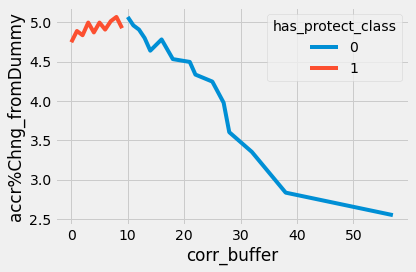

In [190]:
#see buffer vs accuracy % change from dummy classifier
sns.lineplot(data=SL_corr_eval, x='corr_buffer', y='accr%Chng_fromDummy', hue='has_protect_class')

<AxesSubplot:xlabel='corr_buffer', ylabel='AUC'>

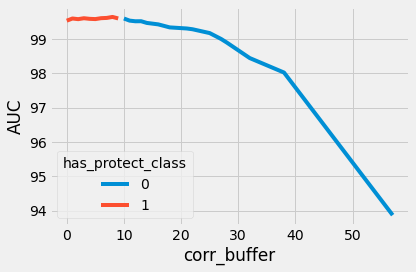

In [191]:
#see buffer vs AUC
sns.lineplot(data=SL_corr_eval, x='corr_buffer', y='AUC', hue='has_protect_class')

## RA Model

In [92]:
%%time
#do evaluation on SNF likelihood model (using feat importance not corr)
#RA_featImp_eval, RA_featImp_ALL = test_model_feats_imprts(dataModels_norm, 'Readmit_90', remove_vars_norm, protect_class)

Wall time: 0 ns


In [93]:
#RA_featImp_eval

In [94]:
#RA_featImp_ALL.head()

In [95]:
%%time
##do evaluation on SNF likelihood model (using corr)
RA_corr_eval, RA_featImp_ALL = test_model_feats_corr(dataModels_norm, 'Readmit_90', leave_out, protect_class)

getting 30k rows sample of data
pearson corr complete
kendall corr complete
spearman corr complete
0.0 % buffer done in 0.21 min
1.0 % buffer done in 0.19 min
2.0 % buffer done in 0.19 min
3.0 % buffer done in 0.18 min
4.0 % buffer done in 0.2 min
5.0 % buffer done in 0.19 min
6.0 % buffer done in 0.18 min
7.000000000000001 % buffer done in 0.18 min
8.0 % buffer done in 0.21 min
9.0 % buffer done in 0.21 min
10.0 % buffer done in 0.15 min
11.0 % buffer done in 0.14 min
12.0 % buffer done in 0.14 min
13.0 % buffer done in 0.14 min
14.000000000000002 % buffer done in 0.13 min
15.0 % buffer done in 0.11 min
16.0 % buffer done in 0.13 min
17.0 % buffer done in 0.14 min
18.0 % buffer done in 0.1 min
19.0 % buffer done in 0.11 min
20.0 % buffer done in 0.12 min
21.0 % buffer done in 0.11 min
22.0 % buffer done in 0.09 min
23.0 % buffer done in 0.1 min
24.0 % buffer done in 0.1 min
26.0 % buffer done in 0.1 min
27.0 % buffer done in 0.11 min
28.000000000000004 % buffer done in 0.08 min
28.999

In [96]:
#save corr eval
RA_corr_eval.to_excel('RA_corr_evalnewDataOPS&CLAIMS.xlsx')
RA_corr_eval

corr_buffer        AUC  num_cols  train_acc   test_acc  dummy_acc  \
0           0.0  84.222804       187  99.983333  83.966667  80.383333   
1           1.0  84.169137       162  99.979167  84.633333  80.383333   
2           2.0  84.152878       144  99.983333  84.250000  80.383333   
3           3.0  84.338365       128  99.979167  84.383333  80.383333   
4           4.0  84.167340       116  99.983333  84.300000  80.383333   
5           5.0  84.157414       105  99.975000  84.216667  80.383333   
6           6.0  84.293946        97  99.975000  84.233333  80.383333   
7           7.0  84.134169        84  99.958333  84.250000  80.383333   
8           8.0  83.885714        76  99.958333  84.450000  80.383333   
9           9.0  84.162443        69  99.958333  84.383333  80.383333   
10         10.0  84.204211        61  99.954167  84.116667  80.383333   
11         11.0  84.107605        56  99.958333  84.133333  80.383333   
12         12.0  84.037731        51  99.958333  84.183333  80.383333   
13         13.0  84.057029        48  99.958333  84.466667  80.383333   
14         14.0  83.890787        41  99.950000  84.150000  80.383333   
15         15.0  84.076962        39  99.908333  84.166667  80.383333   
16         16.0  83.890003        37  99.766667  84.300000  80.383333   
17         17.0  84.192980        33  99.679167  84.266667  80.383333   
18         18.0  83.003639        30  98.962500  83.716667  80.383333   
19         19.0  82.573933        27  98.970833  83.766667  80.383333   
20         20.0  81.913414        25  98.908333  83.033333  80.383333   
21         21.0  81.571162        21  98.550000  82.966667  80.383333   
22         22.0  81.225008        18  95.550000  82.866667  80.383333   
23         23.0  81.385155        17  95.550000  83.050000  80.383333   
24         24.0  81.359383        16  95.462500  83.150000  80.383333   
25         26.0  80.147176        15  94.941667  82.500000  80.383333   
26         27.0  80.311586        14  94.745833  82.666667  80.383333   
27         28.0  79.460207        12  94.483333  81.566667  80.383333   
28         29.0  79.330694        11  94.354167  81.483333  80.383333   
29         30.0  79.680239        10  94.275000  81.733333  80.383333   
30         31.0  78.881619         8  93.779167  81.483333  80.383333   
31         32.0  78.665973         7  93.625000  81.400000  80.383333   
32         33.0  77.174096         6  91.929167  80.516667  80.383333   
33         34.0  76.173227         4  91.129167  79.983333  80.383333   
34         36.0  75.721616         2  86.408333  79.950000  80.383333   
35         38.0  74.523678         1  82.691667  79.483333  80.383333   

      pstv_f1  has_protect_class  total_rows  \
0   44.902635                  1       30000   
1   47.850679                  1       30000   
2   46.640316                  1       30000   
3   46.426529                  1       30000   
4   46.598639                  1       30000   
5   47.124511                  1       30000   
6   46.674183                  1       30000   
7   46.519525                  1       30000   
8   47.731092                  1       30000   
9   47.270681                  1       30000   
10  47.143649                  1       30000   
11  47.111111                  1       30000   
12  48.056924                  1       30000   
13  48.106904                  1       30000   
14  47.429519                  0       30000   
15  47.687225                  0       30000   
16  48.241758                  0       30000   
17  48.695652                  0       30000   
18  47.501343                  0       30000   
19  48.628692                  0       30000   
20  46.251320                  0       30000   
21  47.101449                  0       30000   
22  46.290491                  0       30000   
23  46.837428                  0       30000   
24  47.535029                  0       30000   
25  48.122530                  0       30000   
26  47

In [97]:
#read previous corr if needed
#RA_corr_eval = pd.read_excel('RA_corr_eval.xlsx')

In [98]:
#get subset of this data where no protected classes are used
#RA_corr_eval_NoProtct_Cls = RA_corr_eval[RA_corr_eval.has_protect_class==0]
#RA_corr_eval_NoProtct_Cls

corr_buffer        AUC  num_cols  train_acc   test_acc  dummy_acc  \
14         14.0  83.890787        41  99.950000  84.150000  80.383333   
15         15.0  84.076962        39  99.908333  84.166667  80.383333   
16         16.0  83.890003        37  99.766667  84.300000  80.383333   
17         17.0  84.192980        33  99.679167  84.266667  80.383333   
18         18.0  83.003639        30  98.962500  83.716667  80.383333   
19         19.0  82.573933        27  98.970833  83.766667  80.383333   
20         20.0  81.913414        25  98.908333  83.033333  80.383333   
21         21.0  81.571162        21  98.550000  82.966667  80.383333   
22         22.0  81.225008        18  95.550000  82.866667  80.383333   
23         23.0  81.385155        17  95.550000  83.050000  80.383333   
24         24.0  81.359383        16  95.462500  83.150000  80.383333   
25         26.0  80.147176        15  94.941667  82.500000  80.383333   
26         27.0  80.311586        14  94.745833  82.666667  80.383333   
27         28.0  79.460207        12  94.483333  81.566667  80.383333   
28         29.0  79.330694        11  94.354167  81.483333  80.383333   
29         30.0  79.680239        10  94.275000  81.733333  80.383333   
30         31.0  78.881619         8  93.779167  81.483333  80.383333   
31         32.0  78.665973         7  93.625000  81.400000  80.383333   
32         33.0  77.174096         6  91.929167  80.516667  80.383333   
33         34.0  76.173227         4  91.129167  79.983333  80.383333   
34         36.0  75.721616         2  86.408333  79.950000  80.383333   
35         38.0  74.523678         1  82.691667  79.483333  80.383333   

      pstv_f1  has_protect_class  total_rows  \
14  47.429519                  0       30000   
15  47.687225                  0       30000   
16  48.241758                  0       30000   
17  48.695652                  0       30000   
18  47.501343                  0       30000   
19  48.628692                  0       30000   
20  46.251320                  0       30000   
21  47.101449                  0       30000   
22  46.290491                  0       30000   
23  46.837428                  0       30000   
24  47.535029                  0       30000   
25  48.122530                  0       30000   
26  47.843531                  0       30000   
27  45.355731                  0       30000   
28  45.135802                  0       30000   
29  46.009852                  0       30000   
30  44.310777                  0       30000   
31  43.465046                  0       30000   
32  40.929763                  0       30000   
33  38.251928                  0       30000   
34  35.771490                  0       30000   
35  27.885179                  0       30000   

                                           model_vars  runTime_min  \
14  [Historical_DX1_readmission_risk_OPS, total_ad...         0.13   
15  [Historical_DX1_readmission_risk_OPS, total_ad...         0.11   
16  [Historical_DX1_readmission_risk_OPS, total_ad...         0.13   
17  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.14   
18  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.10   
19  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.11   
20  [Streak_90_OPS, total_admit_count_OPS, No_Stre...         0.12   
21  [Streak_90_OPS, total_admit_count_OPS, No_Stre...         0.11   
22  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.09   
23  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.10   
24  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.10   
25  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.10   
26  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.11   
27  [Streak_90_OPS, total_admit_count_CLAIMS, tota...         0.08   
28  [total_admit_count_CLAIMS, Streak_90_OPS, Adj_...         0.08   
29  [total_admit_count_CLAIMS, Streak_90_OPS, Adj_...         0.08   
30  [total_admit_count_CLAIMS

In [259]:
#get all the different models with the highest accuracy to the 10th place (1 decimal)
RA_top0 = RA_corr_eval[np.max(round(RA_corr_eval.AUC,1))==round(RA_corr_eval.AUC,1)]
#within these top models, choose the one with the least number of columns
RA_vars0 = list(RA_top0[np.min(RA_top0.num_cols) == RA_top0.num_cols]['model_vars'])[0]

 
#set max # of columns to use as cutoff
max_cols = 30
#if there are two many columns then round to the 1st place (no decimal)
if len(RA_vars0) > max_cols:
    RA_top1 = RA_corr_eval[np.max(round(RA_corr_eval.AUC))==round(RA_corr_eval.AUC)]
    RA_vars1 = list(RA_top1[np.min(RA_top1.num_cols) == RA_top1.num_cols]['model_vars'])[0]
    #if still too many columns, then use floor to the integer
    if len(RA_vars1) > max_cols:
        RA_top2 = RA_corr_eval[np.max(RA_corr_eval.AUC.apply(np.floor))==RA_corr_eval.AUC.apply(np.floor)]
        RA_vars2 = list(RA_top2[np.min(RA_top2.num_cols) == RA_top2.num_cols]['model_vars'])[0]
        #if still too many columns, choose whichever has less columns
        if len(RA_vars2) >= len(RA_vars1):
            RA_vars=RA_vars1
        else:
            RA_vars= RA_vars2
    else:
        RA_vars=RA_vars1
else:
    RA_vars = RA_vars0
#see alphabetical vars
set(RA_vars)

{'Adj_DX_1_RR_CLAIMS',
 'Adj_NPI_risk_CLAIMS',
 'Adj_NPI_risk_OPS',
 'CLIENT_WELLCARE',
 'Count_180_CLAIMS',
 'Count_180_OPS',
 'Count_365_CLAIMS',
 'Count_365_OPS',
 'DATA_SOURCE_CLAIM',
 'DATA_SOURCE_OPERATIONAL',
 'DAYS',
 'EPI_IS_READMIT_30_DAY',
 'EPI_IS_READMIT_90_DAY',
 'Historical_DX1_SNF_risk_CLAIMS',
 'Historical_DX1_readmission_risk_CLAIMS',
 'Historical_DX1_readmission_risk_OPS',
 'Historical_DX2_readmission_risk_CLAIMS',
 'Historical_DX3_readmission_risk_CLAIMS',
 'No_Streak_CLAIMS',
 'No_Streak_OPS',
 'Office_Visit_Counts',
 'Office_Visit_Counts_recent',
 'PRIOR_POS_21',
 'PRIOR_POS_nan',
 'Streak_90_CLAIMS',
 'Streak_90_OPS',
 'grouping_noReadmitsMAX_CLAIMS',
 'grouping_noReadmitsMAX_OPS',
 'hist_readmit_90_rate_byMemMonths_CLAIMS',
 'ofv_byMemMonths',
 'ofv_byMemMonths_recent',
 'total_admit_count_CLAIMS',
 'total_admit_count_OPS'}

In [254]:
#top model
RA_corr_eval[RA_corr_eval.num_cols == len(RA_vars)]

corr_buffer       AUC  num_cols  train_acc   test_acc  dummy_acc  \
17         17.0  84.19298        33  99.679167  84.266667  80.383333   

      pstv_f1  has_protect_class  total_rows  \
17  48.695652                  0       30000   

                                           model_vars  runTime_min  \
17  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.14   

    accr%Chng_fromDummy  
17             4.831018

In [102]:
#see top 10 feature importances
RA_featImp_ALL.head(10)

feature  importance
0   Historical_DX1_readmission_risk_CLAIMS      0.0427
1                       Adj_DX_1_RR_CLAIMS      0.0407
2                         Streak_90_CLAIMS      0.0258
3                                     DAYS      0.0214
4                         Count_365_CLAIMS      0.0213
5                         No_Streak_CLAIMS      0.0211
6           Historical_DX1_SNF_risk_CLAIMS      0.0210
7  hist_readmit_90_rate_byMemMonths_CLAIMS      0.0197
8                         Adj_NPI_risk_OPS      0.0179
9                      Adj_NPI_risk_CLAIMS      0.0175

<AxesSubplot:xlabel='corr_buffer', ylabel='accr%Chng_fromDummy'>

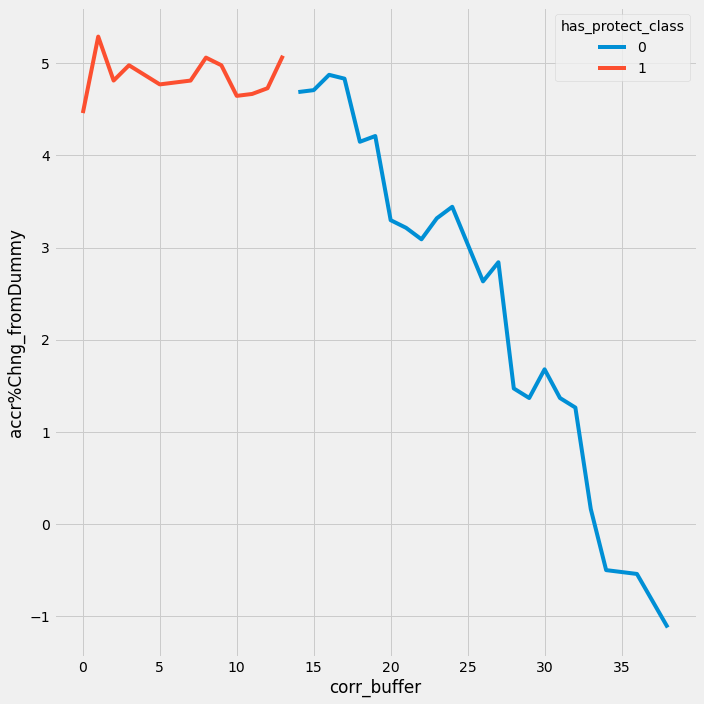

In [200]:
#see buffer vs accuracy % change from dummy classifier
sns.lineplot(data=RA_corr_eval, x='corr_buffer', y='accr%Chng_fromDummy', hue='has_protect_class')

## Resplit Train/Test and assign variables
### For Home RA & SNF RA models

In [367]:
#create dataframes to train the home ra/snf ra models

#for snf ra model, just use data where patient went to snf/irf after
#drop vars not needed by model
snf_df = dataModels_norm[dataModels_norm['SNF_or_IRF']==1].drop(columns=['SNF', 'SNF_or_IRF'])
#for home ra model, just use data where patient DID NOT GO to snf/irf after
#drop vars not needed by model
home_df = dataModels_norm[dataModels_norm['SNF_or_IRF']==0].drop(columns=['SNF', 'SNF_or_IRF'])
#see lens of both dfs
print(len(snf_df))
print(len(home_df))

30000
0


### SNF RA Model -  Create List of Independent Variables
From Corrs

In [105]:
%%time
#do evaluation on SNF likelihood model (using feat importance not corr)
#SNF_featImp_eval, SNF_featImp_ALL = test_model_feats_imprts(snf_df, 'Readmit_90', remove_vars_norm, protect_class)

Wall time: 0 ns


In [106]:
#SNF_featImp_eval

In [107]:
#SNF_featImp_ALL 

In [368]:
%%time
#do evaluation on SNF model
SNF_corr_eval, SNF_featImp_ALL = test_model_feats_corr(snf_df, 'Readmit_90', leave_out, protect_class)

pearson corr complete
kendall corr complete
spearman corr complete
0.0 % buffer done in 0.26 min
1.0 % buffer done in 0.28 min
2.0 % buffer done in 0.26 min
3.0 % buffer done in 0.2 min
4.0 % buffer done in 0.18 min
5.0 % buffer done in 0.19 min
6.0 % buffer done in 0.17 min
7.000000000000001 % buffer done in 0.14 min
8.0 % buffer done in 0.15 min
9.0 % buffer done in 0.13 min
10.0 % buffer done in 0.12 min
11.0 % buffer done in 0.11 min
12.0 % buffer done in 0.11 min
13.0 % buffer done in 0.12 min
14.000000000000002 % buffer done in 0.11 min
15.0 % buffer done in 0.1 min
17.0 % buffer done in 0.09 min
19.0 % buffer done in 0.08 min
20.0 % buffer done in 0.07 min
21.0 % buffer done in 0.07 min
23.0 % buffer done in 0.06 min
24.0 % buffer done in 0.06 min
Wall time: 8min 38s


In [369]:
SNF_corr_eval.to_excel('SNF_corr_evalnewDataOPS&CLAIMS.xlsx')
SNF_corr_eval

corr_buffer        AUC  num_cols   train_acc   test_acc  dummy_acc  \
0           0.0  75.444536       185  100.000000  74.500000  68.516667   
1           1.0  75.402241       144  100.000000  74.583333  68.516667   
2           2.0  75.309236       121  100.000000  74.600000  68.516667   
3           3.0  75.678746        94  100.000000  74.316667  68.516667   
4           4.0  75.297814        75   99.958333  74.400000  68.516667   
5           5.0  75.589379        56   99.962500  74.333333  68.516667   
6           6.0  75.658027        47   99.958333  74.233333  68.516667   
7           7.0  75.693574        42   99.950000  73.916667  68.516667   
8           8.0  75.373255        36   99.887500  74.100000  68.516667   
9           9.0  75.366462        28   99.858333  74.016667  68.516667   
10         10.0  72.388860        26   97.445833  72.750000  68.516667   
11         11.0  72.825815        24   97.404167  72.766667  68.516667   
12         12.0  73.267540        23   97.287500  73.133333  68.516667   
13         13.0  71.925546        22   97.195833  72.350000  68.516667   
14         14.0  71.968485        21   97.112500  72.450000  68.516667   
15         15.0  72.282392        19   97.025000  72.733333  68.516667   
16         17.0  70.133764        14   95.104167  71.033333  68.516667   
17         19.0  69.674983        13   95.025000  70.600000  68.516667   
18         20.0  64.877154         8   89.400000  67.966667  68.516667   
19         21.0  64.894931         6   82.841667  69.083333  68.516667   
20         23.0  64.138171         5   80.512500  68.016667  68.516667   
21         24.0  63.542737         1   71.495833  67.700000  68.516667   

      pstv_f1  has_protect_class  total_rows  \
0   46.801113                  1       30000   
1   46.993396                  1       30000   
2   47.412008                  1       30000   
3   48.097002                  0       30000   
4   48.282828                  0       30000   
5   48.043185                  0       30000   
6   47.946128                  0       30000   
7   47.746244                  0       30000   
8   48.440610                  0       30000   
9   48.834920                  0       30000   
10  47.545717                  0       30000   
11  47.188106                  0       30000   
12  48.432502                  0       30000   
13  46.673095                  0       30000   
14  46.694615                  0       30000   
15  47.898089                  0       30000   
16  47.333333                  0       30000   
17  46.963319                  0       30000   
18  40.715608                  0       30000   
19  41.867753                  0       30000   
20  37.471489                  0       30000   
21  26.311787                  0       30000   

                                           model_vars  runTime_min  \
0   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.26   
1   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.28   
2   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.26   
3   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.20   
4   [grouping_noReadmitsMAX_CLAIMS, Historical_DX1...         0.18   
5   [Historical_DX1_readmission_risk_OPS, total_ad...         0.19   
6   [Historical_DX1_readmission_risk_OPS, total_ad...         0.17   
7   [Historical_DX1_readmission_risk_OPS, Streak_9...         0.14   
8   [Historical_DX1_readmission_risk_OPS, Streak_9...         0.15   
9   [Historical_DX1_readmission_risk_OPS, Streak_9...         0.13   
10  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.12   
11  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.11   
12  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.11   
13  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.12   
14  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.11   
15  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.10   
16  [H

In [370]:
SNF_featImp_ALL.head(10)

feature  importance
0  Historical_DX1_readmission_risk_CLAIMS      0.0290
1                      Adj_DX_1_RR_CLAIMS      0.0243
2                        Adj_NPI_risk_OPS      0.0212
3                                    DAYS      0.0207
4                     Adj_NPI_risk_CLAIMS      0.0198
5          Historical_DX1_SNF_risk_CLAIMS      0.0193
6                              MEMBER_AGE      0.0190
7                                 E_NOVEH      0.0187
8                              RPL_THEME2      0.0185
9                              RPL_THEME4      0.0179

In [371]:
#use if needed to load saved data in
#SNF_corr_eval = pd.read_excel('SNF_corr_eval.xlsx')

In [372]:
#get subset of this data where no protected classes are used
SNF_corr_eval_NoProtct_Cls = SNF_corr_eval[SNF_corr_eval.has_protect_class==0]
SNF_corr_eval_NoProtct_Cls

corr_buffer        AUC  num_cols   train_acc   test_acc  dummy_acc  \
3           3.0  75.678746        94  100.000000  74.316667  68.516667   
4           4.0  75.297814        75   99.958333  74.400000  68.516667   
5           5.0  75.589379        56   99.962500  74.333333  68.516667   
6           6.0  75.658027        47   99.958333  74.233333  68.516667   
7           7.0  75.693574        42   99.950000  73.916667  68.516667   
8           8.0  75.373255        36   99.887500  74.100000  68.516667   
9           9.0  75.366462        28   99.858333  74.016667  68.516667   
10         10.0  72.388860        26   97.445833  72.750000  68.516667   
11         11.0  72.825815        24   97.404167  72.766667  68.516667   
12         12.0  73.267540        23   97.287500  73.133333  68.516667   
13         13.0  71.925546        22   97.195833  72.350000  68.516667   
14         14.0  71.968485        21   97.112500  72.450000  68.516667   
15         15.0  72.282392        19   97.025000  72.733333  68.516667   
16         17.0  70.133764        14   95.104167  71.033333  68.516667   
17         19.0  69.674983        13   95.025000  70.600000  68.516667   
18         20.0  64.877154         8   89.400000  67.966667  68.516667   
19         21.0  64.894931         6   82.841667  69.083333  68.516667   
20         23.0  64.138171         5   80.512500  68.016667  68.516667   
21         24.0  63.542737         1   71.495833  67.700000  68.516667   

      pstv_f1  has_protect_class  total_rows  \
3   48.097002                  0       30000   
4   48.282828                  0       30000   
5   48.043185                  0       30000   
6   47.946128                  0       30000   
7   47.746244                  0       30000   
8   48.440610                  0       30000   
9   48.834920                  0       30000   
10  47.545717                  0       30000   
11  47.188106                  0       30000   
12  48.432502                  0       30000   
13  46.673095                  0       30000   
14  46.694615                  0       30000   
15  47.898089                  0       30000   
16  47.333333                  0       30000   
17  46.963319                  0       30000   
18  40.715608                  0       30000   
19  41.867753                  0       30000   
20  37.471489                  0       30000   
21  26.311787                  0       30000   

                                           model_vars  runTime_min  \
3   [MCG_CATEGORY_Inpatient Rehabilitation Facilit...         0.20   
4   [grouping_noReadmitsMAX_CLAIMS, Historical_DX1...         0.18   
5   [Historical_DX1_readmission_risk_OPS, total_ad...         0.19   
6   [Historical_DX1_readmission_risk_OPS, total_ad...         0.17   
7   [Historical_DX1_readmission_risk_OPS, Streak_9...         0.14   
8   [Historical_DX1_readmission_risk_OPS, Streak_9...         0.15   
9   [Historical_DX1_readmission_risk_OPS, Streak_9...         0.13   
10  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.12   
11  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.11   
12  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.11   
13  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.12   
14  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.11   
15  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.10   
16  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.09   
17  [Historical_DX1_readmission_risk_OPS, total_ad...         0.08   
18  [Streak_90_OPS, Adj_DX_1_RR_CLAIMS, Count_180_...         0.07   
19  [Streak_90_OPS, Count_180_CLAIMS, Count_365_CL...         0.07   
20  [Count_180_CLAIMS, Count_365_CLAIMS, No_Streak...         0.06   
21           [Historical_DX1_readmission_risk_CLAIMS]         0.06   

    accr%Chng_fromDummy  
3              8.465094  
4              8.586719  
5              8.489419  
6              8.343469  
7              7.881294  
8    

In [373]:
#get list of variables in SNF model 
#with highest AUC
#THAT DO NOT USE PROTECTED CLASSES

#use this one when loading from excel
#SNF_vars = ast.literal_eval(list(SNF_corr_eval_NoProtct_Cls[np.max(SNF_corr_eval_NoProtct_Cls.AUC)==SNF_corr_eval_NoProtct_Cls.AUC]['model_vars'])[0])
#SNF_vars = list(SNF_corr_eval_NoProtct_Cls[np.max(SNF_corr_eval_NoProtct_Cls.AUC)==SNF_corr_eval_NoProtct_Cls.AUC]['model_vars'])[0]

#set(SNF_vars)

In [374]:
#get all the different models with the highest accuracy to the 10th place (1 decimal)
SNF_top0 = SNF_corr_eval[np.max(round(SNF_corr_eval.AUC,1))==round(SNF_corr_eval.AUC,1)]
#within these top models, choose the one with the least number of columns
SNF_vars0 = list(SNF_top0[np.min(SNF_top0.num_cols) == SNF_top0.num_cols]['model_vars'])[0]

 
#set max # of columns to use as cutoff
max_cols = 30
#if there are two many columns then round to the 1st place (no decimal)
if len(SNF_vars0) > max_cols:
    SNF_top1 = SNF_corr_eval[np.max(round(SNF_corr_eval.AUC))==round(SNF_corr_eval.AUC)]
    SNF_vars1 = list(SNF_top1[np.min(SNF_top1.num_cols) == SNF_top1.num_cols]['model_vars'])[0]
    #if still too many columns, then use floor to the integer
    if len(SNF_vars1) > max_cols:
        SNF_top2 = SNF_corr_eval[np.max(SNF_corr_eval.AUC.apply(np.floor))==SNF_corr_eval.AUC.apply(np.floor)]
        SNF_vars2 = list(SNF_top2[np.min(SNF_top2.num_cols) == SNF_top2.num_cols]['model_vars'])[0]
        #if still too many columns, choose whichever has less columns
        if len(SNF_vars2) >= len(SNF_vars1):
            SNF_vars=SNF_vars1
        else:
            SNF_vars= SNF_vars2
    else:
        SNF_vars=SNF_vars1
else:
    SNF_vars = SNF_vars0
    
#see alphabetical vars
set(SNF_vars)

{'Adj_DX_1_RR_CLAIMS',
 'Adj_DX_1_RR_OPS',
 'Adj_DX_2_RR_OPS',
 'Adj_NPI_risk_OPS',
 'Count_180_CLAIMS',
 'Count_180_OPS',
 'Count_365_CLAIMS',
 'Count_365_OPS',
 'DAYS',
 'EPI_IS_READMIT_30_DAY',
 'EPI_IS_READMIT_90_DAY',
 'Historical_DX1_readmission_risk_CLAIMS',
 'Historical_DX1_readmission_risk_OPS',
 'Historical_DX2_readmission_risk_CLAIMS',
 'Historical_DX2_readmission_risk_OPS',
 'Historical_DX3_readmission_risk_CLAIMS',
 'MCG_CATEGORY_Inpatient Rehabilitation Facility (IRF)',
 'No_Streak_CLAIMS',
 'No_Streak_OPS',
 'PRIOR_POS_21',
 'PRIOR_POS_nan',
 'Streak_90_CLAIMS',
 'Streak_90_OPS',
 'grouping_noReadmitsMAX_CLAIMS',
 'hist_readmit_90_rate_byMemMonths_CLAIMS',
 'hist_readmit_90_rate_byMemMonths_OPS',
 'total_admit_count_CLAIMS',
 'total_admit_count_OPS'}

In [375]:
len(SNF_vars)

28

In [376]:
#see top model
SNF_corr_eval[SNF_corr_eval.num_cols == len(SNF_vars)]

corr_buffer        AUC  num_cols  train_acc   test_acc  dummy_acc  \
9          9.0  75.366462        28  99.858333  74.016667  68.516667   

    pstv_f1  has_protect_class  total_rows  \
9  48.83492                  0       30000   

                                          model_vars  runTime_min  \
9  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.13   

   accr%Chng_fromDummy  
9             8.027244

<AxesSubplot:xlabel='corr_buffer', ylabel='accr%Chng_fromDummy'>

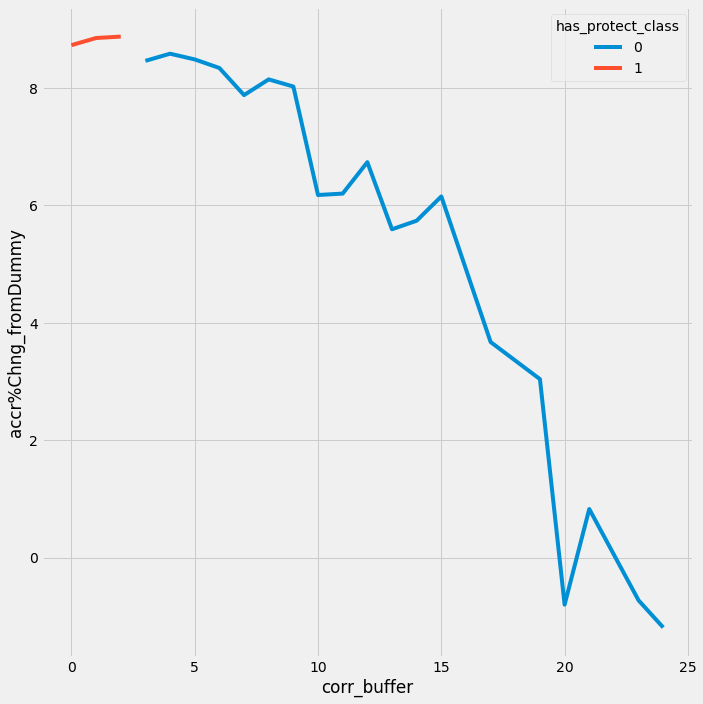

In [377]:
#see buffer vs accuracy % change from dummy classifier
sns.lineplot(data=SNF_corr_eval, x='corr_buffer', y='accr%Chng_fromDummy', hue='has_protect_class')

### HOME RA Model -  Create List of Independent Variables
From Corrs

In [117]:
%%time
#do evaluation on SNF likelihood model (using feat importance not corr)
#Home_featImp_eval, Home_featImp_ALL = test_model_feats_imprts(home_df, 'Readmit_90',remove_vars_norm, protect_class)

Wall time: 0 ns


In [118]:
#Home_featImp_eval

In [119]:
#Home_featImp_ALL.head()

In [120]:
%%time
#do evaluation on SNF model
Home_corr_eval, Home_featImp_ALL = test_model_feats_corr(home_df, 'Readmit_90',leave_out, protect_class)

getting 30k rows sample of data
pearson corr complete
kendall corr complete
spearman corr complete
0.0 % buffer done in 0.19 min
1.0 % buffer done in 0.18 min
2.0 % buffer done in 0.18 min
3.0 % buffer done in 0.19 min
4.0 % buffer done in 0.17 min
5.0 % buffer done in 0.16 min
6.0 % buffer done in 0.16 min
7.000000000000001 % buffer done in 0.16 min
8.0 % buffer done in 0.14 min
9.0 % buffer done in 0.14 min
10.0 % buffer done in 0.12 min
11.0 % buffer done in 0.12 min
12.0 % buffer done in 0.12 min
13.0 % buffer done in 0.1 min
14.000000000000002 % buffer done in 0.11 min
15.0 % buffer done in 0.12 min
17.0 % buffer done in 0.1 min
18.0 % buffer done in 0.09 min
19.0 % buffer done in 0.1 min
20.0 % buffer done in 0.09 min
21.0 % buffer done in 0.08 min
23.0 % buffer done in 0.08 min
25.0 % buffer done in 0.07 min
26.0 % buffer done in 0.06 min
27.0 % buffer done in 0.06 min
28.000000000000004 % buffer done in 0.09 min
28.999999999999996 % buffer done in 0.07 min
30.0 % buffer done in

In [121]:
#save output to excel
Home_corr_eval.to_excel('Home_corr_evalnewDataOPS&CLAIMS.xlsx')
Home_corr_eval

corr_buffer        AUC  num_cols  train_acc   test_acc  dummy_acc  \
0           0.0  84.155689       188  99.979167  86.366667  81.733333   
1           1.0  84.084626       163  99.975000  86.033333  81.733333   
2           2.0  84.171736       144  99.975000  86.216667  81.733333   
3           3.0  84.388842       131  99.979167  85.883333  81.733333   
4           4.0  84.379400       117  99.979167  86.033333  81.733333   
5           5.0  84.502912       102  99.970833  85.900000  81.733333   
6           6.0  84.471981        92  99.970833  85.933333  81.733333   
7           7.0  83.999394        81  99.958333  85.916667  81.733333   
8           8.0  84.350004        73  99.950000  85.933333  81.733333   
9           9.0  84.244688        65  99.941667  85.766667  81.733333   
10         10.0  84.447561        59  99.950000  86.383333  81.733333   
11         11.0  84.265489        53  99.945833  85.916667  81.733333   
12         12.0  84.362906        50  99.941667  86.316667  81.733333   
13         13.0  84.204258        46  99.920833  86.166667  81.733333   
14         14.0  84.078821        43  99.920833  86.050000  81.733333   
15         15.0  83.260025        36  99.187500  85.300000  81.733333   
16         17.0  83.415036        33  98.962500  85.383333  81.733333   
17         18.0  82.797988        27  98.937500  85.266667  81.733333   
18         19.0  81.969815        26  98.925000  84.816667  81.733333   
19         20.0  81.846443        23  98.920833  84.883333  81.733333   
20         21.0  81.249953        18  95.683333  84.533333  81.733333   
21         23.0  81.273499        17  95.670833  84.700000  81.733333   
22         25.0  80.242192        16  95.262500  84.100000  81.733333   
23         26.0  80.353052        15  95.170833  84.450000  81.733333   
24         27.0  80.201381        14  95.033333  84.000000  81.733333   
25         28.0  78.820423        12  94.741667  82.533333  81.733333   
26         29.0  78.666371        11  94.675000  82.416667  81.733333   
27         30.0  77.738333         8  94.112500  81.650000  81.733333   
28         32.0  77.384105         7  93.975000  81.683333  81.733333   
29         33.0  75.754030         6  92.437500  81.183333  81.733333   
30         34.0  75.721359         5  92.433333  81.033333  81.733333   
31         35.0  75.285565         4  91.604167  80.866667  81.733333   
32         37.0  75.858016         2  87.216667  81.316667  81.733333   

      pstv_f1  has_protect_class  total_rows  \
0   50.424242                  1       30000   
1   48.840049                  1       30000   
2   50.508677                  1       30000   
3   49.493143                  1       30000   
4   50.059595                  1       30000   
5   49.158654                  1       30000   
6   49.278846                  1       30000   
7   49.732302                  1       30000   
8   49.642005                  1       30000   
9   49.407583                  1       30000   
10  51.628182                  1       30000   
11  50.147493                  1       30000   
12  51.563422                  1       30000   
13  51.233843                  0       30000   
14  50.444050                  0       30000   
15  49.829352                  0       30000   
16  49.684452                  0       30000   
17  50.112867                  0       30000   
18  49.020705                  0       30000   
19  50.082554                  0       30000   
20  49.066959                  0       30000   
21  49.281768                  0       30000   
22  49.201278                  0       30000   
23  50.398724                  0       30000   
24  49.579832                  0       30000   
25  44.432662                  0       30000   
26  44.793302                  0       30000   
27  40.518639                  0       30000   
28  40.754717                  0       30000   
29  40.042485                  0       30000   
30  39.788360                  0 

In [122]:
Home_featImp_ALL.head(10)

feature  importance
0   Historical_DX1_readmission_risk_CLAIMS      0.0411
1                       Adj_DX_1_RR_CLAIMS      0.0389
2  hist_readmit_90_rate_byMemMonths_CLAIMS      0.0269
3                         Streak_90_CLAIMS      0.0255
4                         Count_180_CLAIMS      0.0220
5           Historical_DX1_SNF_risk_CLAIMS      0.0206
6                                     DAYS      0.0201
7                         Count_365_CLAIMS      0.0194
8                         No_Streak_CLAIMS      0.0190
9                         Adj_NPI_risk_OPS      0.0181

In [123]:
#load previously saved data if needed
#Home_corr_eval = pd.read_excel('Home_corr_eval.xlsx')

In [124]:
#get subset of this data where no protected classes are used
#Home_corr_eval_NoProtct_Cls = Home_corr_eval[Home_corr_eval.has_protect_class==0]
#Home_corr_eval_NoProtct_Cls

corr_buffer        AUC  num_cols  train_acc   test_acc  dummy_acc  \
13         13.0  84.204258        46  99.920833  86.166667  81.733333   
14         14.0  84.078821        43  99.920833  86.050000  81.733333   
15         15.0  83.260025        36  99.187500  85.300000  81.733333   
16         17.0  83.415036        33  98.962500  85.383333  81.733333   
17         18.0  82.797988        27  98.937500  85.266667  81.733333   
18         19.0  81.969815        26  98.925000  84.816667  81.733333   
19         20.0  81.846443        23  98.920833  84.883333  81.733333   
20         21.0  81.249953        18  95.683333  84.533333  81.733333   
21         23.0  81.273499        17  95.670833  84.700000  81.733333   
22         25.0  80.242192        16  95.262500  84.100000  81.733333   
23         26.0  80.353052        15  95.170833  84.450000  81.733333   
24         27.0  80.201381        14  95.033333  84.000000  81.733333   
25         28.0  78.820423        12  94.741667  82.533333  81.733333   
26         29.0  78.666371        11  94.675000  82.416667  81.733333   
27         30.0  77.738333         8  94.112500  81.650000  81.733333   
28         32.0  77.384105         7  93.975000  81.683333  81.733333   
29         33.0  75.754030         6  92.437500  81.183333  81.733333   
30         34.0  75.721359         5  92.433333  81.033333  81.733333   
31         35.0  75.285565         4  91.604167  80.866667  81.733333   
32         37.0  75.858016         2  87.216667  81.316667  81.733333   

      pstv_f1  has_protect_class  total_rows  \
13  51.233843                  0       30000   
14  50.444050                  0       30000   
15  49.829352                  0       30000   
16  49.684452                  0       30000   
17  50.112867                  0       30000   
18  49.020705                  0       30000   
19  50.082554                  0       30000   
20  49.066959                  0       30000   
21  49.281768                  0       30000   
22  49.201278                  0       30000   
23  50.398724                  0       30000   
24  49.579832                  0       30000   
25  44.432662                  0       30000   
26  44.793302                  0       30000   
27  40.518639                  0       30000   
28  40.754717                  0       30000   
29  40.042485                  0       30000   
30  39.788360                  0       30000   
31  36.853685                  0       30000   
32  36.342987                  0       30000   

                                           model_vars  runTime_min  \
13  [Historical_DX1_readmission_risk_OPS, total_ad...         0.10   
14  [Historical_DX1_readmission_risk_OPS, total_ad...         0.11   
15  [Historical_DX1_readmission_risk_OPS, total_ad...         0.12   
16  [Historical_DX1_readmission_risk_OPS, Streak_9...         0.10   
17  [Streak_90_OPS, total_admit_count_OPS, No_Stre...         0.09   
18  [Streak_90_OPS, total_admit_count_OPS, No_Stre...         0.10   
19  [Streak_90_OPS, total_admit_count_OPS, No_Stre...         0.09   
20  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.08   
21  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.08   
22  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.07   
23  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.06   
24  [Streak_90_OPS, total_admit_count_OPS, total_a...         0.06   
25  [Streak_90_OPS, total_admit_count_CLAIMS, tota...         0.09   
26  [total_admit_count_CLAIMS, Streak_90_OPS, Adj_...         0.07   
27  [total_admit_count_CLAIMS, Adj_DX_1_RR_CLAIMS,...         0.06   
28  [total_admit_count_CLAIMS, Adj_DX_1_RR_CLAIMS,...         0.06   
29  [total_admit_count_CLAIMS, Count_365_CLAIMS, h...         0.05   
30  [total_admit_count_CLAIMS, Count_365_CLAIMS, h...         0.06   
31  [Historical_DX1_readmission_risk_CLAIMS, Count...         0.06   
32  [Historical_DX1_readmission_risk_CLAIMS, Strea...        

In [263]:
#get all the different models with the highest accuracy to the 10th place (1 decimal)
Home_top0 = Home_corr_eval[np.max(round(Home_corr_eval.AUC,1))==round(Home_corr_eval.AUC,1)]
#within these top models, choose the one with the least number of columns
Home_vars0 = list(Home_top0[np.min(Home_top0.num_cols) == Home_top0.num_cols]['model_vars'])[0]

 
#set max # of columns to use as cutoff
max_cols = 30
#if there are two many columns then round to the 1st place (no decimal)
if len(Home_vars0) > max_cols:
    Home_top1 = Home_corr_eval[np.max(round(Home_corr_eval.AUC))==round(Home_corr_eval.AUC)]
    Home_vars1 = list(Home_top1[np.min(Home_top1.num_cols) == Home_top1.num_cols]['model_vars'])[0]
    #if still too many columns, then use floor to the integer
    if len(Home_vars1) > max_cols:
        Home_top2 = Home_corr_eval[np.max(Home_corr_eval.AUC.apply(np.floor))==Home_corr_eval.AUC.apply(np.floor)]
        Home_vars2 = list(Home_top2[np.min(Home_top2.num_cols) == Home_top2.num_cols]['model_vars'])[0]
        #if still too many columns, choose whichever has less columns
        if len(Home_vars2) >= len(Home_vars1):
            Home_vars=Home_vars1
        else:
            Home_vars= Home_vars2
    else:
        Home_vars=Home_vars1
else:
    Home_vars = Home_vars0

#see alphabetical list of variables
set(Home_vars)


{'Adj_DX_1_RR_CLAIMS',
 'Adj_DX_1_RR_OPS',
 'Adj_DX_1_SNF_rate_CLAIMS',
 'Adj_NPI_risk_CLAIMS',
 'Adj_NPI_risk_OPS',
 'CLIENT_HORIZON',
 'CLIENT_WELLCARE',
 'COVID_START_FLAG',
 'Count_180_CLAIMS',
 'Count_180_OPS',
 'Count_365_CLAIMS',
 'Count_365_OPS',
 'DATA_SOURCE_CLAIM',
 'DATA_SOURCE_OPERATIONAL',
 'DAYS',
 'EPI_IS_READMIT_30_DAY',
 'EPI_IS_READMIT_90_DAY',
 'HAS_ADT',
 'HAS_CENSUS',
 'Historical_DX1_SNF_risk_CLAIMS',
 'Historical_DX1_readmission_risk_CLAIMS',
 'Historical_DX1_readmission_risk_OPS',
 'Historical_DX2_readmission_risk_CLAIMS',
 'Historical_DX3_readmission_risk_CLAIMS',
 'ICD_CAT_Pregnancy, childbirth and the puerperium',
 'Longitude',
 'MEMBER_AGE',
 'MEMBER_MONTHS',
 'No_Streak_CLAIMS',
 'No_Streak_OPS',
 'Office_Visit_Counts',
 'Office_Visit_Counts_recent',
 'PRIOR_POS_21',
 'PRIOR_POS_nan',
 'Streak_90_CLAIMS',
 'Streak_90_OPS',
 'grouping_noReadmitsMAX_CLAIMS',
 'grouping_noReadmitsMAX_OPS',
 'hist_readmit_90_rate_byMemMonths_CLAIMS',
 'ofv_byMemMonths',
 'ofv_

In [264]:
#see top model
Home_corr_eval[Home_corr_eval.num_cols==len(Home_vars)]

corr_buffer        AUC  num_cols  train_acc  test_acc  dummy_acc  \
14         14.0  84.078821        43  99.920833     86.05  81.733333   

     pstv_f1  has_protect_class  total_rows  \
14  50.44405                  0       30000   

                                           model_vars  runTime_min  \
14  [Historical_DX1_readmission_risk_OPS, total_ad...         0.11   

    accr%Chng_fromDummy  
14             5.281403

<AxesSubplot:xlabel='corr_buffer', ylabel='accr%Chng_fromDummy'>

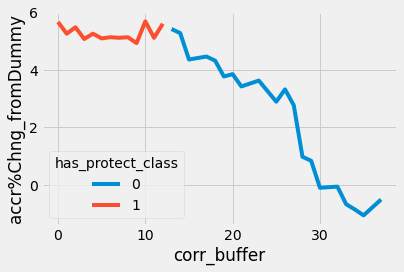

In [193]:
#see buffer vs accuracy % change from dummy classifier
sns.lineplot(data=Home_corr_eval, x='corr_buffer', y='accr%Chng_fromDummy', hue='has_protect_class')

## Model Variance 

In [129]:
#print(home_auc-snf_auc)

## Create Recommendations

# NEED TO FIX THIS
# ADD IN OTHER 2 MODEL PREDS TO EXPLORE 

In [130]:
#how many columns in the all data
len(dataModels_norm.columns)

324

# TESTING PRED/RECC LOOP

In [131]:
print('this sample had', round(dataModels_norm.Discharge_Home.mean()*100, 2), '% of patients sent home')

this sample had 90.65 % of patients sent home


In [132]:
#get snf & home model final info
#for rows that didn't use protected classes, use model with max AUC
#SNF_final_model_info = SNF_corr_eval_NoProtct_Cls[np.max(SNF_corr_eval_NoProtct_Cls.AUC)==SNF_corr_eval_NoProtct_Cls.AUC]
#Home_final_model_info = Home_corr_eval_NoProtct_Cls[np.max(Home_corr_eval_NoProtct_Cls.AUC)==Home_corr_eval_NoProtct_Cls.AUC]

In [268]:
#get snf & home model final info
#get top models
#for rows that could have use protected classes, use model with max AUC & Least amount of columns
SNF_final_model_info = SNF_corr_eval[SNF_corr_eval.num_cols == len(SNF_vars)]
Home_final_model_info = Home_corr_eval[Home_corr_eval.num_cols == len(Home_vars)]

In [269]:
#reset corr_buffer column so join below works
Home_final_model_info['corr_buffer'] = 0
SNF_final_model_info['corr_buffer'] = 0

<ipython-input-269-646d37565207>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Home_final_model_info['corr_buffer'] = 0
<ipython-input-269-646d37565207>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNF_final_model_info['corr_buffer'] = 0


In [270]:
%%time

#change column names of home/snf corr dfs to designate they are snf vs home
#join two dfs on corr threshold
SNF_Home_corr_eval = Home_final_model_info.add_suffix('_Home').rename(columns={'corr_buffer_Home':'corr_buffer'}).merge(SNF_final_model_info.add_suffix('_SNF').rename(columns={'corr_buffer_SNF':'corr_buffer'}))
SNF_Home_corr_eval

#loop thru corr and train model using variable column
#for index, row in SNF_Home_corr_eval.iterrows():

start_time = time.time()
#print('using corr of', row['corr_buffer'],'...') #print for visual control
#create target variable
#y = dataModels_norm['Readmit_90']

#create home/snf X and y variables
XH = home_df[Home_vars]
yH = home_df['Readmit_90']
XS = snf_df[SNF_vars]
yS = snf_df['Readmit_90']

# setting up testing and training sets
#split train/test sets for home model
X_trainH, X_testH, y_trainH, y_testH = train_test_split(XH, 
                                                    yH, 
                                                    test_size=0.2, #Assign test size, note also used to create small data sets to train on
                                                    random_state=42, #assign random state for reproducbility
                                                    stratify=yH #use this for classification problems
                                                   )


#split train/test for home SNF model
X_trainS, X_testS, y_trainS, y_testS = train_test_split(XS, 
                                                yS, 
                                                test_size=0.2, #Assign test size, note also used to create small data sets to train on
                                                random_state=42, #assign random state for reproducbility
                                                stratify=yS #use this for classification problems
                                              )
                                                        


print('training models with', SNF_Home_corr_eval.num_cols_Home[0], 'home vars and', SNF_Home_corr_eval.num_cols_SNF[0], 'snf vars...')
#create/fit models
#create Home model 
modelHome = RandomForestClassifier()
#fit model
modelHome.fit(X_trainH,y_trainH,sample_weight=None)

#create SNF  model
modelSNF = RandomForestClassifier()
#fit model
modelSNF.fit(X_trainS,y_trainS,sample_weight=None)

print('generating feature importances...') #print for visual control
#get feature importances for Home Model
#create empty list
feat_listHome = []
#get feature importances
feat_impHome = sorted(zip(map(lambda x:round(x,4), modelHome.feature_importances_),XH),reverse = True)
#add feat imp to list
for num, feat in feat_impHome:
    feat_listHome.append([feat,num])
#covnert to dataframe
featImp_evalHome= pd.DataFrame(feat_listHome, columns=['feature', 'importance'])

#get feature importances for SNF Model
#create empty list
feat_listSNF = []
#get feature importances
feat_impSNF = sorted(zip(map(lambda x:round(x,4), modelSNF.feature_importances_),XS),reverse = True)
#add feat imp to list
for num, feat in feat_impSNF:
    feat_listSNF.append([feat,num])
#covnert to dataframe
featImp_evalSNF= pd.DataFrame(feat_listSNF, columns=['feature', 'importance'])


print('making predictions...') #print for visual control
#make predictions
#get snf predictions for all rows
dataModels_norm['pred_SNF_RA']  = modelSNF.predict_proba(dataModels_norm[SNF_vars])[:,1]

#get home predictions for all rows
dataModels_norm['pred_Home_RA']  = modelHome.predict_proba(dataModels_norm[Home_vars])[:,1]

print('generating recommendations...')#print for visual control
#create change if home column
dataModels_norm['ChangeIfHome'] =  dataModels_norm['pred_Home_RA'] - dataModels_norm['pred_SNF_RA']
#create zscore based on CIH variable
dataModels_norm['zscore'] = stats.zscore(dataModels_norm['ChangeIfHome'])
#create column, if zscore above 90% threshold, send SNF else home
#dataModels_norm['Recommendation'] = np.where(dataModels_norm.zscore>1.645, 'SNF', 'Home')
#except when sickle cell
dataModels_norm['Recommendation'] = np.where(dataModels_norm.sickle==1,'Path of Care Override - Sickle Cell',
                                             np.where(dataModels_norm.zscore>1.645, 'SNF', 'Home'))


#create numerical column for Recommendation
dataModels_norm['RecommendationBinary'] = np.where(dataModels_norm['Recommendation']=='Home', 1,0)

#define col of interest
col_int = ['pred_SNF_RA', 'pred_Home_RA', 'ChangeIfHome',
   'Recommendation',
   'Discharge_Home', 'Readmit_90', 'zscore']
#create dataframe with only cols of interest
#df_int = claims_data[col_int]
df_int = dataModels_norm[col_int]
#create column that has only home/snf for actual discharges 
df_int['Discharge_Home_name'] = np.where(df_int['Discharge_Home']==1, 'Home', 'SNF')
#create followed poc variable so it is correct
df_int['FollowedPoC'] = np.where(df_int.Recommendation==df_int.Discharge_Home_name, 'Followed', 'Did Not Follow')

#generate recommendation summary stats
cl_list = []
#get sum of all readmits divided by count of all patients (split by if followed poc or not)
fpoc_RR = df_int.groupby('FollowedPoC').sum()['Readmit_90']/df_int.groupby('FollowedPoC').count()['Readmit_90']
#get followed POC vs not RR %s
f_RR = fpoc_RR['Followed']
dnf_RR = fpoc_RR['Did Not Follow']

#get difference in followed poc readmit rate - did not follow poc readmit rate
diff = fpoc_RR['Followed']-fpoc_RR['Did Not Follow']
#print('Difference in Readmit Rates',diff)
#get percent change of the readmit rates if followed vs not followed poc readmit rate
diff_chng = diff/np.abs(fpoc_RR['Did Not Follow'])
#print('Percentage Change in Readmit Rates',diff_chng)
#get percent difference of the readmit rates if followed vs not followed poc readmit rate
diff_prct = np.abs(fpoc_RR['Did Not Follow']-fpoc_RR['Followed'])/((fpoc_RR['Did Not Follow']+fpoc_RR['Followed'])/2)
#print('Percentage Difference in Readmit Rates',diff_prct)
#get sum of all readmits divided by count of all patients (split by RECCOMENDATION AND if followed poc or not)
fpoc_RR_byRecc = df_int.groupby(['Recommendation', 'FollowedPoC']).sum()['Readmit_90']/df_int.groupby(['Recommendation', 'FollowedPoC']).count()['Readmit_90']
#get home recc RR scores
f_RR_Home = fpoc_RR_byRecc['Home']['Followed'] 
dnf_RR_Home = fpoc_RR_byRecc['Home']['Did Not Follow']
#get snf reccRR scores
f_RR_SNF = fpoc_RR_byRecc['SNF']['Followed']
dnf_RR_SNF = fpoc_RR_byRecc['SNF']['Did Not Follow']

#get difference in followed poc readmit rate - did not follow poc readmit rate
#for snf/home reccs
diff_snf =  f_RR_SNF - dnf_RR_SNF
diff_home =  f_RR_Home - dnf_RR_Home
#get percent change of the readmit rates if followed vs not followed poc readmit rate
#for snf/home reccs
diff_chng_SNF = diff_snf/np.abs(dnf_RR_SNF)
diff_chng_Home = diff_home/np.abs(dnf_RR_Home)
#get percent difference of the readmit rates if followed vs not followed poc readmit rate
#for snf/home reccs
diff_prct_snf = np.abs(dnf_RR_SNF-f_RR_SNF)/((dnf_RR_SNF+f_RR_SNF)/2)
diff_prct_home = np.abs(dnf_RR_Home-f_RR_Home)/((dnf_RR_Home+f_RR_Home)/2)


#get % discharged to home
home_dis_prct =  df_int['Recommendation'].tolist().count('Home')/len(df_int)
##append all to list
cl_list.append([f_RR, dnf_RR, diff, diff_chng, diff_prct, home_dis_prct, f_RR_Home,dnf_RR_Home, f_RR_SNF, dnf_RR_SNF,
             diff_snf,diff_home , diff_chng_SNF,diff_chng_Home,diff_prct_snf,diff_prct_home ]) 

#create dataframe
poc_RRdiffs = pd.DataFrame(cl_list, columns=['RR_FolPOC', 'RR_NotFolPOC','RR_diff', 'RR_prcnt_change', 'RR_prcnt_diff',
    'home_dischr_prct', 'RR_FolPOC_Home', 'RR_NotFolPOC_Home','RR_FolPOC_SNF', 'RR_NotFolPOC_SNF',
     'RR_diff_SNF', 'RR_diff_Home','RR_prcnt_change_SNF', 'RR_prcnt_change_Home','RR_prcnt_diff_SNF','RR_prcnt_diff_Home'])


#get col of interest for POC recc data
#multiply probablity by 100 to make percentage (and match other data)
RRdiffs_int = poc_RRdiffs[['RR_prcnt_change','home_dischr_prct','RR_prcnt_change_SNF','RR_prcnt_change_Home']]*100

#add POC recommendation evaluation data to corr_eval data 
SNF_Home_corr_eval.loc[SNF_Home_corr_eval.index[0], list(RRdiffs_int.columns)] = RRdiffs_int.values.tolist()[0]


#get end time and run time duration
end_time = time.time()
run_time = end_time - start_time 
print('Duration in secs:', round(run_time, 2)) #print for visual control
print('\n')



training models with 43 home vars and 66 snf vars...
generating feature importances...
making predictions...
generating recommendations...


<timed exec>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Duration in secs: 60.4


Wall time: 1min


In [271]:
SNF_Home_corr_eval

corr_buffer   AUC_Home  num_cols_Home  train_acc_Home  test_acc_Home  \
0            0  84.078821             43       99.920833          86.05   

   dummy_acc_Home  pstv_f1_Home  has_protect_class_Home  total_rows_Home  \
0       81.733333      50.44405                       0            30000   

                                     model_vars_Home  runTime_min_Home  \
0  [Historical_DX1_readmission_risk_OPS, total_ad...              0.11   

   accr%Chng_fromDummy_Home    AUC_SNF  num_cols_SNF  train_acc_SNF  \
0                  5.281403  76.506632            66      99.966946   

   test_acc_SNF  dummy_acc_SNF  pstv_f1_SNF  has_protect_class_SNF  \
0     74.273128      68.678414    50.255537                      0   

   total_rows_SNF                                     model_vars_SNF  \
0           11346  [grouping_noReadmitsMAX_CLAIMS, Historical_DX1...   

   runTime_min_SNF  accr%Chng_fromDummy_SNF  RR_prcnt_change  \
0             0.05                 8.146248       -86.084289   

   home_dischr_prct  RR_prcnt_change_SNF  RR_prcnt_change_Home  
0         90.966667           -25.151499             -77.45189

In [272]:
RRdiffs_int

RR_prcnt_change  home_dischr_prct  RR_prcnt_change_SNF  \
0       -86.084289         90.966667           -25.151499   

   RR_prcnt_change_Home  
0             -77.45189

In [273]:
#save home feature importances to excel
featImp_evalHome.to_excel('featImp_evalHomenewDataOPS&CLAIMS.xlsx')
featImp_evalHome

feature  importance
0             Historical_DX1_readmission_risk_CLAIMS      0.0704
1                                 Adj_DX_1_RR_CLAIMS      0.0701
2                                         MEMBER_AGE      0.0563
3                                               DAYS      0.0514
4                                   Adj_NPI_risk_OPS      0.0489
5                                Adj_NPI_risk_CLAIMS      0.0482
6                     Historical_DX1_SNF_risk_CLAIMS      0.0463
7                                          Longitude      0.0446
8            hist_readmit_90_rate_byMemMonths_CLAIMS      0.0369
9                           Adj_DX_1_SNF_rate_CLAIMS      0.0360
10                                  No_Streak_CLAIMS      0.0340
11                                     MEMBER_MONTHS      0.0314
12                                  Count_180_CLAIMS      0.0302
13                                  Streak_90_CLAIMS      0.0264
14               Historical_DX1_readmission_risk_OPS      0.0256
15                          total_admit_count_CLAIMS      0.0239
16                                  Count_365_CLAIMS      0.0239
17                                   Adj_DX_1_RR_OPS      0.0232
18            Historical_DX3_readmission_risk_CLAIMS      0.0220
19                                   ofv_byMemMonths      0.0206
20            Historical_DX2_readmission_risk_CLAIMS      0.0205
21                            ofv_byMemMonths_recent      0.0202
22                               Office_Visit_Counts      0.0186
23                        Office_Visit_Counts_recent      0.0177
24                                     PRIOR_POS_nan      0.0166
25                                     Count_180_OPS      0.0143
26                             EPI_IS_READMIT_90_DAY      0.0130
27                                     No_Streak_OPS      0.0127
28                     grouping_noReadmitsMAX_CLAIMS      0.0124
29                                     Count_365_OPS      0.0120
30                                     Streak_90_OPS      0.0115
31                             total_admit_count_OPS      0.0113
32                                      PRIOR_POS_21      0.0087
33                                  COVID_START_FLAG      0.0068
34                        grouping_noReadmitsMAX_OPS      0.0066
35                             EPI_IS_READMIT_30_DAY      0.0066
36                                           HAS_ADT      0.0037
37                                 DATA_SOURCE_CLAIM      0.0035
38                           DATA_SOURCE_OPERATIONAL      0.0034
39                                        HAS_CENSUS      0.0033
40                                   CLIENT_WELLCARE      0.0024
41                                    CLIENT_HORIZON      0.0021
42  ICD_CAT_Pregnancy, childbirth and the puerperium      0.0019

In [274]:
#save snf feature importances to excel
featImp_evalSNF.to_excel('featImp_evalSNFnewDataOPS&CLAIMS.xlsx')
featImp_evalSNF

feature  importance
0                                  Adj_DX_1_RR_CLAIMS      0.0731
1              Historical_DX1_readmission_risk_CLAIMS      0.0683
2                                                DAYS      0.0589
3                                    Adj_NPI_risk_OPS      0.0460
4                                 Adj_NPI_risk_CLAIMS      0.0447
5                                            Latitude      0.0408
6                                           Longitude      0.0392
7                                  MCG_30THPERCENTILE      0.0275
8                                  MCG_40THPERCENTILE      0.0247
9                                    Streak_90_CLAIMS      0.0238
10                       Count_365_byMemMonths_CLAIMS      0.0219
11                Historical_DX1_readmission_risk_OPS      0.0218
12                       Count_180_byMemMonths_CLAIMS      0.0206
13                                    Adj_DX_1_RR_OPS      0.0202
14             Historical_DX2_readmission_risk_CLAIMS      0.0200
15             Historical_DX3_readmission_risk_CLAIMS      0.0188
16                                    ofv_byMemMonths      0.0169
17                     Historical_DX3_SNF_risk_CLAIMS      0.0168
18                                      MEMBER_MONTHS      0.0167
19            hist_readmit_90_rate_byMemMonths_CLAIMS      0.0164
20                                   Count_365_CLAIMS      0.0160
21                     Historical_DX2_SNF_risk_CLAIMS      0.0158
22                             ofv_byMemMonths_recent      0.0155
23                                   Count_180_CLAIMS      0.0155
24                                Office_Visit_Counts      0.0140
25                             HHA_COUNTY_PROV_COUNTS      0.0135
26                         Office_Visit_Counts_recent      0.0129
27                                   No_Streak_CLAIMS      0.0128
28                      grouping_noReadmitsMAX_CLAIMS      0.0127
29                           total_admit_count_CLAIMS      0.0126
30               hist_readmit_90_rate_byMemMonths_OPS      0.0122
31                Historical_DX2_readmission_risk_OPS      0.0113
32                                      PRIOR_POS_nan      0.0112
33                         SNF_COUNTY_MAX_PROV_RATING      0.0103
34                         HHA_COUNTY_MIN_PROV_RATING      0.0097
35                                    Adj_DX_2_RR_OPS      0.0092
36                                    flu_byMemMonths      0.0086
37                         HHA_COUNTY_MAX_PROV_RATING      0.0082
38                              EPI_IS_READMIT_90_DAY      0.0077
39                                      Streak_90_OPS      0.0072
40                                      Count_180_OPS      0.0071
41                              total_admit_count_OPS      0.0066
42                Historical_DX3_readmission_risk_OPS      0.0066
43                                    snf_hist_CLAIMS      0.0065
44                                       PRIOR_POS_21      0.0065
45                                       PRIOR_POS_31      0.0064
46                              EPI_IS_READMIT_30_DAY      0.0061
47                                 Adj_DX_2_RR_CLAIMS      0.0060
48                                 Adj_DX_3_RR_CLAIMS      0.0058
49                                      No_Streak_OPS      0.0055
50                                      Count_365_OPS      0.0055
51                                         awv_counts      0.0054
52  ICD_CAT_Injury, poisoning and certain other co...      0.0053
53                                         flu_counts      0.0048
54           ICD_CAT_Diseases of the digestive system      0.0046
55                         grouping_noReadmitsMAX_OPS      0.0044
56  MCG_CATEGORY_Inpatient Rehabilitation Facility...      0.0042
57                                    Adj_DX_3_RR_OPS      0.0041
58                      MCG_CATEGORY_Gastroenterology      0.0039
59                                   COVID_START_FLAG      0.0039
60  ICD_CAT_Diseases

### EDA - day by corr_buffer

In [140]:
#show corr_buffer vs home discharge %
#sns.lineplot(data=SNF_Home_corr_eval, x='corr_buffer', y='home_dischr_prct')
#plt.show()

In [141]:
#show AUC & home discharge % by corr_buffer
#sns.lineplot(x='corr_buffer', y='value', hue='variable', 
 #            data=pd.melt(SNF_Home_corr_eval[['corr_buffer', 'home_dischr_prct', 'AUC_Home', 'AUC_SNF']], ['corr_buffer']))

## # of columns vs metrics

In [142]:

#show #cols vs home discharge %
#sns.lineplot(data=SNF_Home_corr_eval, x='num_cols_Home', y='home_dischr_prct')

In [143]:
#show #cols vs home discharge %
#sns.lineplot(data=SNF_Home_corr_eval, x='num_cols_SNF', y='home_dischr_prct')

In [144]:
#show AUC & home discharge % by corr_buffer
#sns.lineplot(x='num_cols_Home', y='value', hue='variable', 
 #            data=pd.melt(SNF_Home_corr_eval[['num_cols_Home', 'home_dischr_prct', 'AUC_Home', 'AUC_SNF']], ['num_cols_Home']))

In [145]:
#show AUC & home discharge % by corr_buffer
#sns.lineplot(x='num_cols_SNF', y='value', hue='variable', 
 #            data=pd.melt(SNF_Home_corr_eval[['num_cols_SNF', 'home_dischr_prct', 'AUC_Home', 'AUC_SNF']], ['num_cols_SNF']))

In [146]:
#show snf AUC vs home discharge %
#sns.scatterplot(data=SNF_Home_corr_eval, x='AUC_SNF', y='home_dischr_prct')

In [147]:
#show home auc vs home discharge %
#sns.scatterplot(data=SNF_Home_corr_eval, x='AUC_Home', y='home_dischr_prct')

### EDA - Protected Classes & AUC of 2 models

In [148]:
#do for home corr check AUC vs num cols & has protected class
#sns.lineplot(data=Home_corr_eval, x='num_cols', hue='has_protect_class', y='AUC').set(title='Home model AUC less affected by protected class')

In [149]:
#do for snf corr check AUC vs num cols & has protected class
#sns.lineplot(data=SNF_corr_eval, x='num_cols', hue='has_protect_class', y='AUC').set(title='SNF model AUC less affected by protected class')

In [150]:
#do for snf likelihood corr check AUC vs num cols & has protected class
#sns.lineplot(data=SL_corr_eval, x='num_cols', hue='has_protect_class', y='AUC').set(title='SNF Likely model AUC MORE affected by protected class')

In [151]:
#do for RA model corr check AUC vs num cols & has protected class
#sns.lineplot(data=RA_corr_eval, x='num_cols', hue='has_protect_class', y='AUC').set(title='Risk strat model AUC less affected by protected class')

In [275]:
dataModels_norm[['pred_SNF_RA', 'pred_Home_RA', 'ChangeIfHome', 'zscore',
       'Recommendation', 'RecommendationBinary']].head()

pred_SNF_RA  pred_Home_RA  ChangeIfHome    zscore Recommendation  \
0         0.02          0.00         -0.02  0.185462           Home   
1         0.06          0.00         -0.06  0.002955           Home   
2         0.50          1.00          0.50  2.558043            SNF   
3         0.20          0.44          0.24  1.371752           Home   
4         0.37          0.71          0.34  1.828018            SNF   

   RecommendationBinary  
0                     1  
1                     1  
2                     0  
3                     1  
4                     0

In [276]:
#get % that would be discharged to SNF
#round(len(claims_data[(claims_data.zscore>1.645) & (claims_data.Recommendation=='SNF')])/len(claims_data)*100, 2)
dataModels_norm.Recommendation.value_counts()/len(dataModels_norm)

Home    0.909667
SNF     0.090333
Name: Recommendation, dtype: float64

In [277]:
#look at this data
df_int[(df_int.Recommendation=='SNF')].describe()

pred_SNF_RA  pred_Home_RA  ChangeIfHome  Discharge_Home    Readmit_90  \
count  13550.000000  13550.000000  13550.000000    13550.000000  13550.000000   
mean       0.339696      0.766950      0.427253        0.895572      0.958007   
std        0.155627      0.121117      0.092101        0.305826      0.200580   
min        0.000000      0.310000      0.300000        0.000000      0.000000   
25%        0.220000      0.690000      0.350000        1.000000      1.000000   
50%        0.340000      0.760000      0.410000        1.000000      1.000000   
75%        0.450000      0.850000      0.490000        1.000000      1.000000   
max        0.700000      1.000000      0.790000        1.000000      1.000000   

             zscore  
count  13550.000000  
mean       2.226126  
std        0.420224  
min        1.645512  
25%        1.873644  
50%        2.147404  
75%        2.512416  
max        3.881213

In [278]:
df_int.groupby('Recommendation').describe().T

Recommendation                 Home           SNF
pred_SNF_RA    count  136450.000000  13550.000000
               mean        0.241986      0.339696
               std         0.216283      0.155627
               min         0.000000      0.000000
               25%         0.060000      0.220000
               50%         0.190000      0.340000
               75%         0.360000      0.450000
               max         1.000000      0.700000
pred_Home_RA   count  136450.000000  13550.000000
               mean        0.132888      0.766950
               std         0.219983      0.121117
               min         0.000000      0.310000
               25%         0.000000      0.690000
               50%         0.050000      0.760000
               75%         0.140000      0.850000
               max         1.000000      1.000000
ChangeIfHome   count  136450.000000  13550.000000
               mean       -0.109098      0.427253
               std         0.161175      0.092101
               min        -0.830000      0.300000
               25%        -0.210000      0.350000
               50%        -0.090000      0.410000
               75%        -0.020000      0.490000
               max         0.298333      0.790000
Discharge_Home count  136450.000000  13550.000000
               mean        0.907593      0.895572
               std         0.289601      0.305826
               min         0.000000      0.000000
               25%         1.000000      1.000000
               50%         1.000000      1.000000
               75%         1.000000      1.000000
               max         1.000000      1.000000
Readmit_90     count  136450.000000  13550.000000
               mean        0.114943      0.958007
               std         0.318955      0.200580
               min         0.000000      0.000000
               25%         0.000000      1.000000
               50%         0.000000      1.000000
               75%         0.000000      1.000000
               max         1.000000      1.000000
zscore         count  136450.000000  13550.000000
               mean       -0.221063      2.226126
               std         0.735385      0.420224
               min        -3.510290      1.645512
               25%        -0.681443      1.873644
               50%        -0.133924      2.147404
               75%         0.185462      2.512416
               max         1.637907      3.881213

In [156]:
#look at zscore summary stats
#split by recommendation
#dataModels_norm.groupby('Recommendation').describe()['zscore'].T

In [157]:
#look at change if home summary stats
#split by recommendation
#dataModels_norm.groupby('Recommendation').describe()['ChangeIfHome'].T

# EDA - Recommendations

In [279]:
df_int.head()

pred_SNF_RA  pred_Home_RA  ChangeIfHome Recommendation  Discharge_Home  \
0         0.02          0.00         -0.02           Home               1   
1         0.06          0.00         -0.06           Home               1   
2         0.50          1.00          0.50            SNF               1   
3         0.20          0.44          0.24           Home               1   
4         0.37          0.71          0.34            SNF               1   

   Readmit_90    zscore Discharge_Home_name     FollowedPoC  
0           0  0.185462                Home        Followed  
1           0  0.002955                Home        Followed  
2           1  2.558043                Home  Did Not Follow  
3           0  1.371752                Home        Followed  
4           1  1.828018                Home  Did Not Follow

In [280]:
#define values for the rows we want to drop
#values = ['Hospital','LTAC']

#drop rows that contain any value in the list
#aka drop LTAC and HOS for this analysis
#df_int = df_int[df_int.Discharge_To.isin(values) == False]

In [281]:
#look at readmit summary stats
#split by recc & followed poc
df_int.groupby(['Recommendation','FollowedPoC']).describe()['Readmit_90'].T

Recommendation           Home                           SNF             
FollowedPoC    Did Not Follow       Followed Did Not Follow     Followed
count            12609.000000  123841.000000   12135.000000  1415.000000
mean                 0.386946       0.087249       0.983848     0.736396
std                  0.487070       0.282201       0.126064     0.440743
min                  0.000000       0.000000       0.000000     0.000000
25%                  0.000000       0.000000       1.000000     0.000000
50%                  0.000000       0.000000       1.000000     1.000000
75%                  1.000000       0.000000       1.000000     1.000000
max                  1.000000       1.000000       1.000000     1.000000

In [282]:
#get average readmit rate by if followed poc or not
df_int.groupby(['FollowedPoC']).mean()['Readmit_90']

FollowedPoC
Did Not Follow    0.679680
Followed          0.094582
Name: Readmit_90, dtype: float64

In [283]:
#SNF_Home_corr_eval[['RR_prcnt_change','home_dischr_prct','RR_prcnt_change_SNF','RR_prcnt_change_Home']].to_excel('putInpresention.xlsx')
SNF_Home_corr_eval[['RR_prcnt_change','home_dischr_prct','RR_prcnt_change_SNF','RR_prcnt_change_Home']]

RR_prcnt_change  home_dischr_prct  RR_prcnt_change_SNF  \
0       -86.084289         90.966667           -25.151499   

   RR_prcnt_change_Home  
0             -77.45189

# Visualizations

c:\Program Files\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


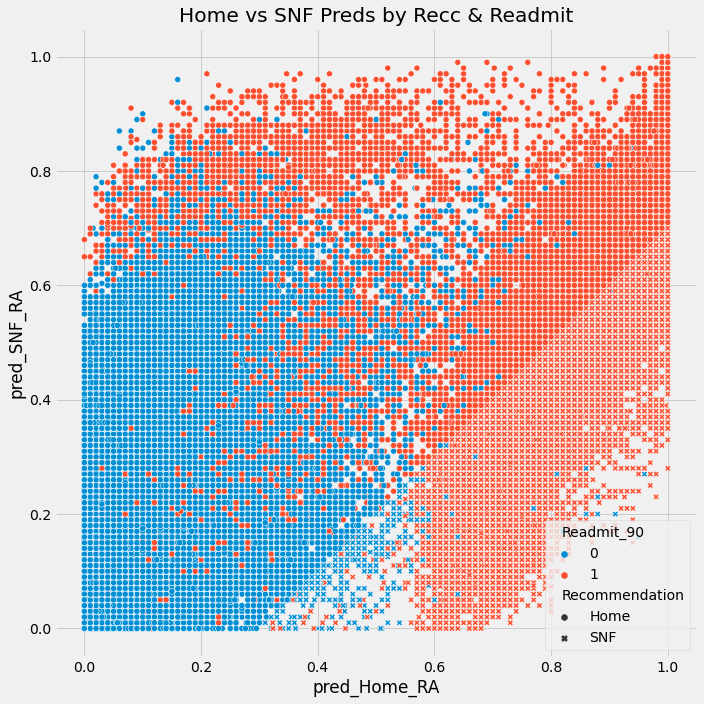

In [284]:
#see scatterplot of home vs snf scores 
#style by recommendation
#hue by readmit
ax = sns.scatterplot(x='pred_Home_RA', y='pred_SNF_RA', style='Recommendation', hue='Readmit_90',data=df_int)
ax.set(xlabel='pred_Home_RA', title='Home vs SNF Preds by Recc & Readmit')
plt.show()

<AxesSubplot:xlabel='pred_Home_RA', ylabel='Count'>

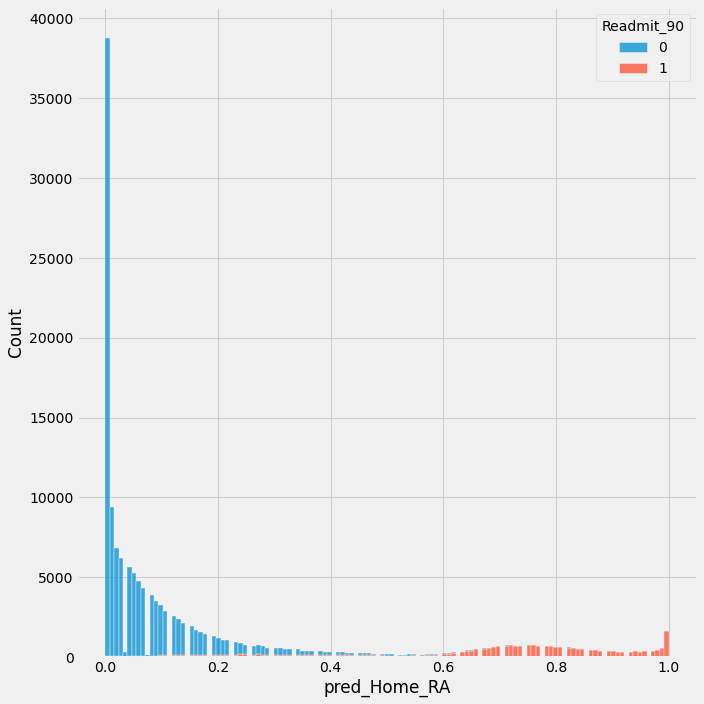

In [285]:
#see hisplot of home prediction scores
sns.histplot(x='pred_Home_RA', hue='Readmit_90',data=df_int, multiple='stack')

<AxesSubplot:xlabel='pred_SNF_RA', ylabel='Count'>

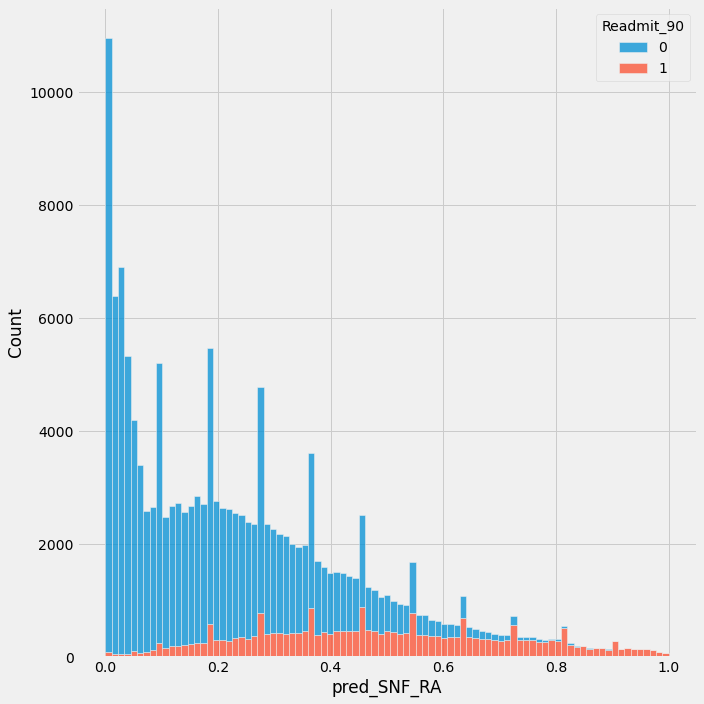

In [286]:
#see hisplot of snf prediction scores
sns.histplot(x='pred_SNF_RA', hue='Readmit_90',data=df_int, multiple='stack')

In [303]:
df_int.head()

pred_SNF_RA  pred_Home_RA  ChangeIfHome Recommendation  Discharge_Home  \
0         0.02          0.00         -0.02           Home               1   
1         0.06          0.00         -0.06           Home               1   
2         0.50          1.00          0.50            SNF               1   
3         0.20          0.44          0.24           Home               1   
4         0.37          0.71          0.34            SNF               1   

   Readmit_90    zscore Discharge_Home_name     FollowedPoC homeRA_binned  \
0           0  0.185462                Home        Followed    (0.0, 0.1]   
1           0  0.002955                Home        Followed    (0.0, 0.1]   
2           1  2.558043                Home  Did Not Follow    (0.9, 1.0]   
3           0  1.371752                Home        Followed    (0.4, 0.5]   
4           1  1.828018                Home  Did Not Follow    (0.7, 0.8]   

  snfRA_binned   CiH_binned  
0   (0.0, 0.1]  (-0.1, 0.0]  
1   (0.0, 0.1]  (-0.1, 0.0]  
2   (0.9, 1.0]   (0.4, 0.5]  
3   (0.4, 0.5]   (0.2, 0.4]  
4   (0.7, 0.8]   (0.2, 0.4]

In [ ]:
#see hisplot of snf prediction scores
sns.barplot(x='pred_SNF_RA', hue='Readmit_90',data=df_int, multiple='stack')

#### For All Recs 

In [287]:
#create list of decmilas 0-1 increasing by .1
bins = np.around(np.linspace(0,1,11), decimals=2).tolist()
#bin the home RA & snf RA predictions in groups of 5%
df_int['homeRA_binned'] = pd.cut(df_int['pred_Home_RA'], bins)
df_int['snfRA_binned'] = pd.cut(df_int['pred_SNF_RA'], bins)
bins

<ipython-input-287-0aad87e96767>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['homeRA_binned'] = pd.cut(df_int['pred_Home_RA'], bins)
<ipython-input-287-0aad87e96767>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['snfRA_binned'] = pd.cut(df_int['pred_SNF_RA'], bins)


[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [288]:
df_int['homeRA_binned'].value_counts()

(0.0, 0.1]    54316
(0.1, 0.2]    19163
(0.2, 0.3]     8104
(0.7, 0.8]     7144
(0.9, 1.0]     5155
(0.8, 0.9]     4882
(0.6, 0.7]     4738
(0.3, 0.4]     4152
(0.4, 0.5]     2478
(0.5, 0.6]     1760
Name: homeRA_binned, dtype: int64

In [289]:
#fill these na with first bin
#all nas are due to 0.000 home risk not being included
df_int['homeRA_binned'] = df_int['homeRA_binned'].astype(str).fillna("(0.0, 0.1]")
#change column back to category
df_int['homeRA_binned'] = df_int.homeRA_binned.astype('category')
#see value counts
df_int['homeRA_binned'].value_counts()

<ipython-input-289-6d5fcd684476>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['homeRA_binned'] = df_int['homeRA_binned'].astype(str).fillna("(0.0, 0.1]")
<ipython-input-289-6d5fcd684476>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['homeRA_binned'] = df_int.homeRA_binned.astype('category')


(0.0, 0.1]    92424
(0.1, 0.2]    19163
(0.2, 0.3]     8104
(0.7, 0.8]     7144
(0.9, 1.0]     5155
(0.8, 0.9]     4882
(0.6, 0.7]     4738
(0.3, 0.4]     4152
(0.4, 0.5]     2478
(0.5, 0.6]     1760
Name: homeRA_binned, dtype: int64

In [290]:
df_int['snfRA_binned'].value_counts()

(0.0, 0.1]    42008
(0.1, 0.2]    26924
(0.2, 0.3]    24468
(0.3, 0.4]    18644
(0.4, 0.5]    12939
(0.5, 0.6]     7899
(0.6, 0.7]     4949
(0.7, 0.8]     3444
(0.8, 0.9]     1940
(0.9, 1.0]     1175
Name: snfRA_binned, dtype: int64

In [291]:
#fill these na with first bin
#all nas are due to 0.000 home risk not being included
df_int['snfRA_binned'] = df_int['snfRA_binned'].astype(str).fillna("(0.0, 0.1]")
#change column back to category
df_int['snfRA_binned'] = df_int.homeRA_binned.astype('category')
#see value counts
df_int['snfRA_binned'].value_counts()

<ipython-input-291-f0669a15f6bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['snfRA_binned'] = df_int['snfRA_binned'].astype(str).fillna("(0.0, 0.1]")
<ipython-input-291-f0669a15f6bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['snfRA_binned'] = df_int.homeRA_binned.astype('category')


(0.0, 0.1]    92424
(0.1, 0.2]    19163
(0.2, 0.3]     8104
(0.7, 0.8]     7144
(0.9, 1.0]     5155
(0.8, 0.9]     4882
(0.6, 0.7]     4738
(0.3, 0.4]     4152
(0.4, 0.5]     2478
(0.5, 0.6]     1760
Name: snfRA_binned, dtype: int64

In [292]:
df_int.describe()['ChangeIfHome']

count    150000.000000
mean         -0.060648
std           0.219171
min          -0.830000
25%          -0.190000
50%          -0.070000
75%           0.000000
max           0.790000
Name: ChangeIfHome, dtype: float64

In [293]:
#get max and min change if home
maxCiH = max(df_int['ChangeIfHome'])
minCiH = min(df_int['ChangeIfHome'])
#create list of decmilas from min to max cih increasing by .1
bins_CH = np.around(np.linspace(minCiH,maxCiH,round((maxCiH - minCiH)*10)), decimals=1).tolist()
#bin the changeifHome in groups of 10%
df_int['CiH_binned'] = pd.cut(df_int['ChangeIfHome'], bins_CH)
bins_CH

<ipython-input-293-7be5a6ed5c04>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['CiH_binned'] = pd.cut(df_int['ChangeIfHome'], bins_CH)


[-0.8,
 -0.7,
 -0.6,
 -0.5,
 -0.4,
 -0.3,
 -0.2,
 -0.1,
 0.0,
 0.1,
 0.2,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8]

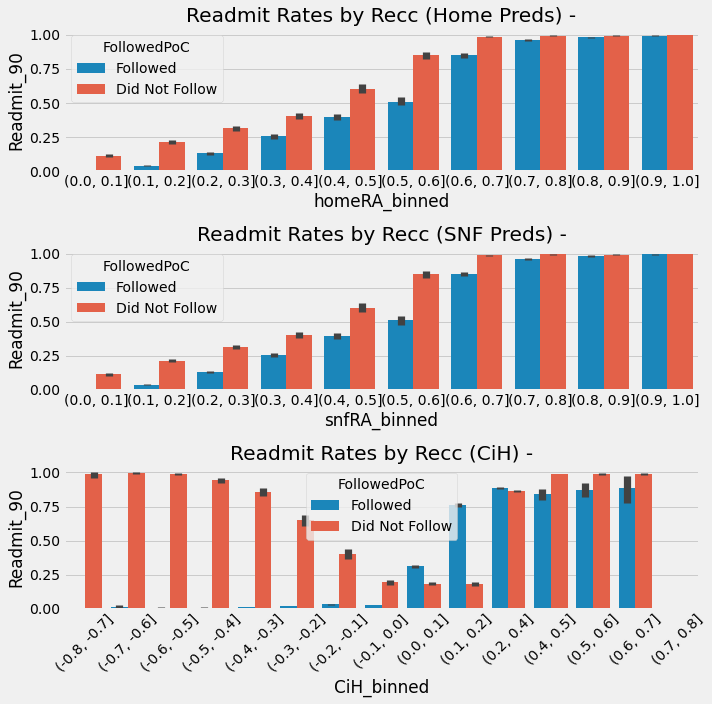

In [294]:

#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(3, 1)
#have the x axis labels rotated so can see them
plt.xticks(rotation=45)
#set size to be larger
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

# Adjust the subplot layout parameters
fig.subplots_adjust(hspace=.8)

#define palette for hue
palette ={"Followed": "C0", "Did Not Follow": "C1"}

#look at readmisstion rates by homeRA bin split by recc
#filter out bins that have less than 100 counts
sns.barplot(x='homeRA_binned', y='Readmit_90', hue='FollowedPoC', data=df_int.groupby("homeRA_binned").filter(lambda x: len(x) > 99), ax=axes[0], palette=palette).set(title='Readmit Rates by Recc (Home Preds) -')

#look at readmisstion rates by snfRA bin split by Recc
#filter out bins that have less than 100 counts
sns.barplot(x='snfRA_binned', y='Readmit_90', hue='FollowedPoC', data=df_int.groupby("snfRA_binned").filter(lambda x: len(x) > 99), ax=axes[1], palette=palette).set(title='Readmit Rates by Recc (SNF Preds) -')

#look at readmisstion rates by cih split by recc
#filter out bins that have less than 100 counts
sns.barplot(x='CiH_binned', y='Readmit_90', hue='FollowedPoC', data=df_int.groupby("CiH_binned").filter(lambda x: len(x) > 99), ax=axes[2], palette=palette).set(title='Readmit Rates by Recc (CiH) -')

plt.show()

#### For Home Recs

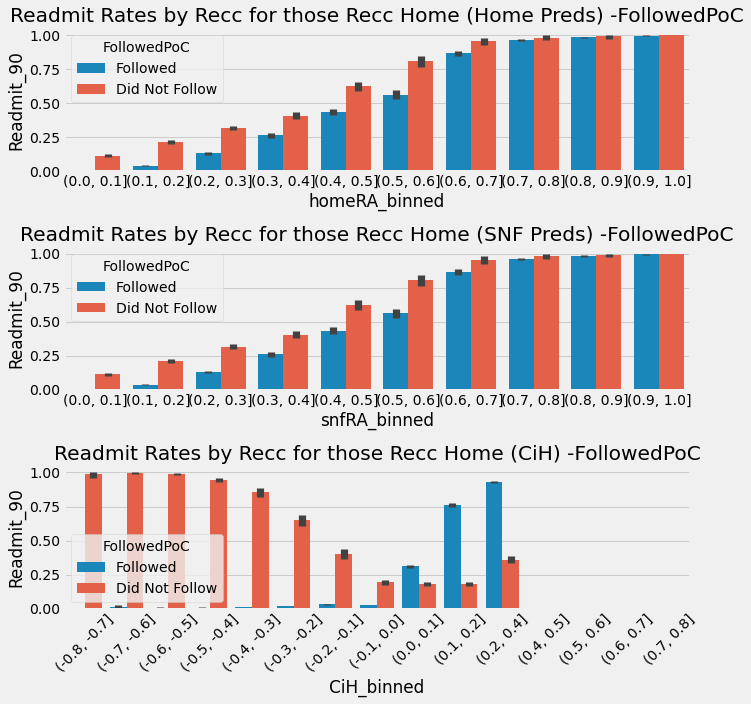

In [295]:
#for home recc
fol = ['FollowedPoC']#,'FollowedPoC_50thres', 'FollowedPoC_snfBuff','FollowedPoC_zscore']
rcs = ['Recommendation']#, 'Recc_50thres', 'Recc_snfBuff', 'Recc_zscore']

for rc, f in zip(fol,rcs): #messed up naming
    #define dimensions of subplots (rows, columns)
    fig, axes = plt.subplots(3, 1)

    #have the x axis labels rotated so can see them
    plt.xticks(rotation=45)
    
    #set size to be larger
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True

    # Adjust the subplot layout parameters
    fig.subplots_adjust(hspace=.4)

    #define palette for hue
    palette ={"Followed": "C0", "Did Not Follow": "C1"}

    #look at readmisstion rates by homeRA bin split by recc
    #filter out bins that have less than 100 counts
    sns.barplot(x='homeRA_binned', y='Readmit_90', hue=rc, data=df_int[df_int[f]=='Home'].groupby("homeRA_binned").filter(lambda x: len(x) > 99), ax=axes[0], palette=palette).set(title='Readmit Rates by Recc for those Recc Home (Home Preds) -'+rc)

    #look at readmisstion rates by snfRA bin split by Recc
    #filter out bins that have less than 100 counts
    sns.barplot(x='snfRA_binned', y='Readmit_90', hue=rc, data=df_int[df_int[f]=='Home'].groupby("snfRA_binned").filter(lambda x: len(x) > 99), ax=axes[1], palette=palette).set(title='Readmit Rates by Recc for those Recc Home (SNF Preds) -'+rc)

    #look at readmisstion rates by cih split by recc
    #filter out bins that have less than 100 counts
    sns.barplot(x='CiH_binned', y='Readmit_90', hue=rc, data=df_int[df_int[f]=='Home'].groupby("CiH_binned").filter(lambda x: len(x) > 99), ax=axes[2], palette=palette).set(title='Readmit Rates by Recc for those Recc Home (CiH) -'+rc)
    
    plt.show()
    print('\n')

#### For SNF Recs

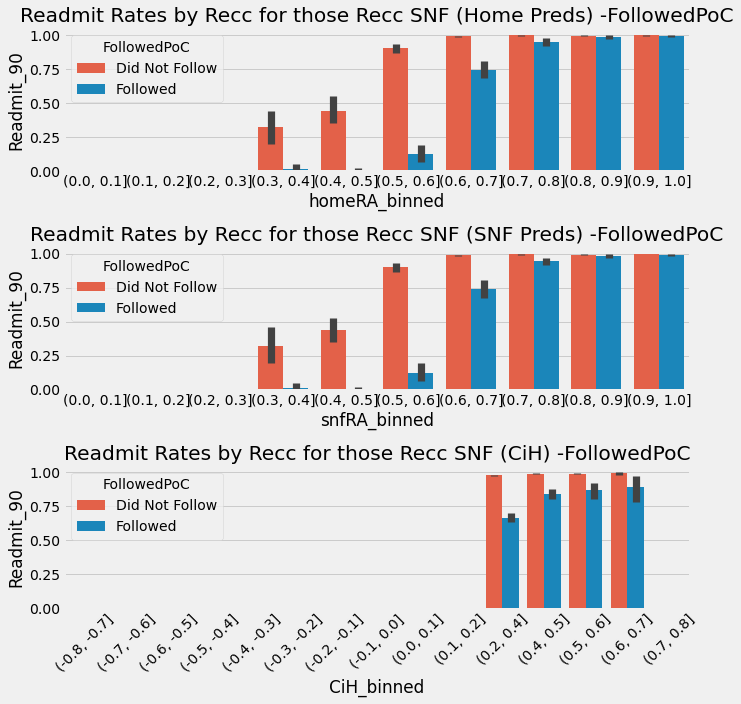

In [296]:
#for SNF recc
fol = ['FollowedPoC']#,'FollowedPoC_50thres', 'FollowedPoC_snfBuff','FollowedPoC_zscore']
rcs = ['Recommendation']#, 'Recc_50thres', 'Recc_snfBuff', 'Recc_zscore']

for rc, f in zip(fol,rcs): #messed up naming
    #define dimensions of subplots (rows, columns)
    fig, axes = plt.subplots(3, 1)
    
    #have the x axis labels rotated so can see them
    plt.xticks(rotation=45)
    
    #set size to be larger
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True

    # Adjust the subplot layout parameters
    fig.subplots_adjust(hspace=.4)

    #define palette for hue
    palette ={"Followed": "C0", "Did Not Follow": "C1"}

    #look at readmisstion rates by homeRA bin split by recc
    #filter out bins that have less than 100 counts
    sns.barplot(x='homeRA_binned', y='Readmit_90', hue=rc, data=df_int[df_int[f]=='SNF'].groupby("homeRA_binned").filter(lambda x: len(x) > 99), ax=axes[0], palette=palette).set(title='Readmit Rates by Recc for those Recc SNF (Home Preds) -'+rc)

    #look at readmisstion rates by snfRA bin split by Recc
    #filter out bins that have less than 100 counts
    sns.barplot(x='snfRA_binned', y='Readmit_90', hue=rc, data=df_int[df_int[f]=='SNF'].groupby("snfRA_binned").filter(lambda x: len(x) > 99), ax=axes[1], palette=palette).set(title='Readmit Rates by Recc for those Recc SNF (SNF Preds) -'+rc)

    #look at readmisstion rates by cih split by recc
    #filter out bins that have less than 100 counts
    sns.barplot(x='CiH_binned', y='Readmit_90', hue=rc, data=df_int[df_int[f]=='SNF'].groupby("CiH_binned").filter(lambda x: len(x) > 99), ax=axes[2], palette=palette).set(title='Readmit Rates by Recc for those Recc SNF (CiH) -'+rc)
    
    plt.show()
    print('\n')

## Train final RA model & SNF Likelihood model

In [297]:
%%time
#create snf likley/RA model X and y variables
XSL = dataModels_norm[SL_vars]
ySL = dataModels_norm['SNF']
XR = dataModels_norm[RA_vars]
yR = dataModels_norm['Readmit_90']

# setting up testing and training sets
#split train/test sets for snf likelihood model
X_trainSL, X_testSL, y_trainSL, y_testSL = train_test_split(XSL, 
                                                    ySL, 
                                                    test_size=0.2, #Assign test size, note also used to create small data sets to train on
                                                    random_state=42, #assign random state for reproducbility
                                                    stratify=ySL #use this for classification problems
                                                   )

#split train/test sets for snf likelihood model
X_trainR, X_testR, y_trainR, y_testR = train_test_split(XR, 
                                                    yR, 
                                                    test_size=0.2, #Assign test size, note also used to create small data sets to train on
                                                    random_state=42, #assign random state for reproducbility
                                                    stratify=yR #use this for classification problems
                                                   )




print('training models with', len(RA_vars), 'readmit model vars and', len(SL_vars), 'snf liklihood vars...')
#create/fit models
#create Readmission model 
modelRA = RandomForestClassifier()
#fit model
modelRA.fit(X_trainR,y_trainR,sample_weight=None)

#create SNF likelihood  model
modelSL = RandomForestClassifier()
#fit model
modelSL.fit(X_trainSL,y_trainSL,sample_weight=None)

print('generating feature importances...') #print for visual control
#get feature importances for RA Model
#create empty list
feat_listRA = []
#get feature importances
feat_impRA = sorted(zip(map(lambda x:round(x,4), modelRA.feature_importances_),XR),reverse = True)
#add feat imp to list
for num, feat in feat_impRA:
    feat_listRA.append([feat,num])
#covnert to dataframe
featImp_evalRA= pd.DataFrame(feat_listRA, columns=['feature', 'importance'])

#get feature importances for SNF Model
#create empty list
feat_listSL = []
#get feature importances
feat_impSL = sorted(zip(map(lambda x:round(x,4), modelSL.feature_importances_),XSL),reverse = True)
#add feat imp to list
for num, feat in feat_impSL:
    feat_listSL.append([feat,num])
#covnert to dataframe
featImp_evalSL= pd.DataFrame(feat_listSL, columns=['feature', 'importance'])

training models with 33 readmit model vars and 27 snf liklihood vars...
generating feature importances...
Wall time: 58.3 s


In [298]:
#save feat importances to excel
featImp_evalSL.to_excel('featImp_evalSLnewDataOPS&CLAIMS.xlsx')
featImp_evalSL

feature  importance
0                                     snf_hist_CLAIMS      0.3314
1                                        snf_hist_OPS      0.1746
2                      Historical_DX1_SNF_risk_CLAIMS      0.0520
3                            Adj_DX_1_SNF_rate_CLAIMS      0.0493
4                                                DAYS      0.0480
5                                          MEMBER_AGE      0.0456
6              Historical_DX1_readmission_risk_CLAIMS      0.0372
7                                        PRIOR_POS_31      0.0318
8                                 Adj_NPI_risk_CLAIMS      0.0279
9                                  Adj_DX_1_RR_CLAIMS      0.0232
10                              total_admit_count_OPS      0.0209
11                              Adj_DX_1_SNF_rate_OPS      0.0188
12                                      Count_365_OPS      0.0181
13                        Historical_DX1_SNF_risk_OPS      0.0153
14                                      Count_180_OPS      0.0152
15                     Historical_DX3_SNF_risk_CLAIMS      0.0151
16                     Historical_DX2_SNF_risk_CLAIMS      0.0140
17                                      No_Streak_OPS      0.0128
18                         grouping_noReadmitsMAX_OPS      0.0113
19                             SNF_COUNTY_PROV_COUNTS      0.0111
20                               REFINED_PRODUCT_CARE      0.0092
21                         HHA_COUNTY_MIN_PROV_RATING      0.0073
22  ICD_CAT_Injury, poisoning and certain other co...      0.0034
23                                           fracture      0.0030
24                                    CLIENT_WELLCARE      0.0027
25                                      CLIENT_OPTIMA      0.0007
26   ICD_CAT_Pregnancy, childbirth and the puerperium      0.0000

In [299]:
#save feat importances to excel
featImp_evalRA.to_excel('featImp_evalRAnewDataOPS&CLAIMS.xlsx')
featImp_evalRA

feature  importance
0    Historical_DX1_readmission_risk_CLAIMS      0.0983
1                        Adj_DX_1_RR_CLAIMS      0.0902
2                       Adj_NPI_risk_CLAIMS      0.0748
3                          Adj_NPI_risk_OPS      0.0734
4                                      DAYS      0.0713
5            Historical_DX1_SNF_risk_CLAIMS      0.0693
6   hist_readmit_90_rate_byMemMonths_CLAIMS      0.0431
7                          Streak_90_CLAIMS      0.0382
8       Historical_DX1_readmission_risk_OPS      0.0361
9    Historical_DX3_readmission_risk_CLAIMS      0.0287
10                   ofv_byMemMonths_recent      0.0282
11                          ofv_byMemMonths      0.0282
12                 total_admit_count_CLAIMS      0.0281
13   Historical_DX2_readmission_risk_CLAIMS      0.0269
14                         Count_365_CLAIMS      0.0269
15                      Office_Visit_Counts      0.0260
16                         No_Streak_CLAIMS      0.0242
17                         Count_180_CLAIMS      0.0236
18               Office_Visit_Counts_recent      0.0227
19            grouping_noReadmitsMAX_CLAIMS      0.0161
20                            PRIOR_POS_nan      0.0156
21                            Streak_90_OPS      0.0132
22                            Count_180_OPS      0.0124
23                            No_Streak_OPS      0.0123
24                    EPI_IS_READMIT_90_DAY      0.0122
25                            Count_365_OPS      0.0114
26                    total_admit_count_OPS      0.0110
27                             PRIOR_POS_21      0.0089
28                    EPI_IS_READMIT_30_DAY      0.0082
29               grouping_noReadmitsMAX_OPS      0.0078
30                        DATA_SOURCE_CLAIM      0.0054
31                  DATA_SOURCE_OPERATIONAL      0.0044
32                          CLIENT_WELLCARE      0.0029

## dx_dict 

In [300]:
#dx_dict = claims_data[['DX1','SNF_DX_1_Risk', 'DX1_Risk']].set_index('DX1').T.to_dict('list')
#dx_dict['0'] = [np.mean(claims_data['SNF']), np.mean(claims_data['Readmit_90'])]

# Model Export

In [378]:
#Model Dictionary
d = {'Discharge_model':modelSL,#SNF likelihood model
     'Discharge_model_cols': SL_vars , #add list of model columns needed for SNF likelihood model
     'RA_model':modelRA, # readmit risk strat model
     'RA_model_cols': RA_vars, #add list of model columns needed for RA model
     'Home': modelHome, #home model
     'Home_cols': Home_vars , #add list of model columns needed for Home model
     'SNF': modelSNF, #snf model 
     'SNF_cols': SNF_vars, #add list of model columns needed for Home model
     #'Scaler': scaler,
     #'pca_demographics': demo_pca,
     'svi_map': svi_data,
     'dxs': icd10,
    # 'dx_risks': dx_dict
    }

#export models
output = open('OPS&CLAIMS_OPTIMIZE_allClient_model_dictionary_02092023.pkl', 'wb')
pickle.dump(d, output)
output.close()

## get NB run time

Home Scores
- FL BLUE HOME AUC: 0.8105898476031107
- WC 10k sample HOME AUC: 0.8132481262327418

In [181]:
#get time of end of code
endCodeTime = time.time()

In [182]:
elapseCodeTime = round(endCodeTime - startCodeTime,2)
print(round(elapseCodeTime/60, 2), 'min - total run time')
print(round((elapseCodeTime/60)/60, 2), 'hr - total run time')

34.82 min - total run time
0.58 hr - total run time


In [183]:
secProw = round(elapseCodeTime/len(claims_data), 2)
print('this run took', secProw, 'secs per input table row')
print('this means the full 330k row run would take approximately', secProw*330000, 'secs')
print(round((secProw*330000)/60, 2), 'min')
print(round((secProw*330000)/60/60, 2), 'hrs')

this run took 0.01 secs per input table row
this means the full 330k row run would take approximately 3300.0 secs
55.0 min
0.92 hrs


# EDA

In [184]:
#save input data to .csv
#claims_data.to_csv('fl_blue_input_data_wcFL.csv')

In [185]:
#load saved data
#claims_data_csv = pd.read_csv('fl_blue_input_data_wcFL.csv')

In [186]:
#len(claims_data_csv.columns)

In [187]:
#len(SNF_data)

In [188]:
%%time
#view input data using pandas profiling
#set minimal=True for larger dataset

#profile = ProfileReport(dataModels_norm,minimal=True)
#profile.to_file("wc_3yr_30k_rows_EDA_output.html")

Wall time: 0 ns
